In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.filterwarnings('ignore')

In [132]:
import os
# 1. Load FAO Food Price Index (FPI)

fao_path = "./Food_price_indices_data_may629 (2).xls"  # Replace with your path
fao_df = pd.read_excel(fao_path, sheet_name=0, skiprows=2)

# Keep only columns that are not 'Unnamed'
fao_columns = [c for c in fao_df.columns if 'Unnamed' not in c]
fao_df = fao_df[fao_columns]

# Melt to long format
fao_long = fao_df.melt(
    id_vars=['Date'],
    var_name='Commodity',
    value_name='FPI'
)

# Add Year and Month
fao_long['Year'] = fao_long['Date'].dt.year
fao_long['Month'] = fao_long['Date'].dt.month

print("FAO FPI long shape:", fao_long.shape)
fao_long.head()

# 2. Load FAO monthly Food CPI (.dta)

fcpi_path = "./Inflation-data/fcpi_m.dta"  # Replace with your path
fcpi_df = pd.read_stata(fcpi_path)

# Keep only Country + numeric monthly columns (ignore _Note)
fcpi_df = fcpi_df[['Country'] + [c for c in fcpi_df.columns if c.startswith('_') and c[1:].isdigit()]]

# Melt wide to long
fcpi_long = fcpi_df.melt(
    id_vars=['Country'],
    var_name='YearMonth',
    value_name='Food_CPI'
)

# Convert YearMonth to datetime
fcpi_long['YearMonth'] = fcpi_long['YearMonth'].str.replace('_','')
fcpi_long['Date'] = pd.to_datetime(fcpi_long['YearMonth'], format='%Y%m')
fcpi_long['Year'] = fcpi_long['Date'].dt.year
fcpi_long['Month'] = fcpi_long['Date'].dt.month
fcpi_long.drop(columns=['YearMonth'], inplace=True)

print("FAO Food CPI long shape:", fcpi_long.shape)
fcpi_long.head()


# 3. Load World Bank CPI

cpi_path = "./API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195 (1)/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv"
cpi_df = pd.read_csv(cpi_path, skiprows=4)

# Melt wide to long
cpi_long = cpi_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='CPI'
)

# Keep only numeric years
cpi_long = cpi_long[cpi_long['Year'].str.isnumeric()]
cpi_long['Year'] = cpi_long['Year'].astype(int)
cpi_long.dropna(subset=['CPI'], inplace=True)

print("World Bank CPI long shape:", cpi_long.shape)
cpi_long.head()


# 4. Load World Bank GDP Deflator

gdp_path = "./API_NY.GDP.DEFL.KD.ZG_DS2_en_csv_v2_22672 (1)/API_NY.GDP.DEFL.KD.ZG_DS2_en_csv_v2_22672.csv"
gdp_df = pd.read_csv(gdp_path, skiprows=4)

# Melt wide to long
gdp_long = gdp_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year',
    value_name='GDP_Deflator'
)

# Keep only numeric years
gdp_long = gdp_long[gdp_long['Year'].str.isnumeric()]
gdp_long['Year'] = gdp_long['Year'].astype(int)
gdp_long.dropna(subset=['GDP_Deflator'], inplace=True)

print("World Bank GDP Deflator long shape:", gdp_long.shape)
gdp_long.head()


# 5. Merge datasets

# Merge FAO FPI with FAO CPI on Year and Month
merged = pd.merge(
    fao_long,
    fcpi_long[['Country','Year','Month','Food_CPI']],
    on=['Year','Month'],
    how='left'
)

# Merge with World Bank CPI on Year
merged = pd.merge(
    merged,
    cpi_long[['Country Name','Year','CPI']],
    left_on=['Country','Year'],
    right_on=['Country Name','Year'],
    how='left'
)

# Merge with GDP Deflator on Year
merged = pd.merge(
    merged,
    gdp_long[['Country Name','Year','GDP_Deflator']],
    left_on=['Country','Year'],
    right_on=['Country Name','Year'],
    how='left'
)

# Drop redundant columns
merged.drop(columns=['Country Name_x','Country Name_y'], inplace=True, errors='ignore')

print("Merged dataset shape:", merged.shape)
merged.head()


FAO FPI long shape: (2334, 5)
FAO Food CPI long shape: (113373, 5)
World Bank CPI long shape: (6284, 6)
World Bank GDP Deflator long shape: (14019, 6)
Merged dataset shape: (398094, 9)


,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
0,NaT,Food Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872,2.999681
2,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Belgium,NaN,3.448312,2.812404
3,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Canada,57.93543,4.780477,3.352302
4,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Chile,NaN,26.036481,22.553700


FAO FPI (Food Price Index)

.Tracks global food prices for different commodities (like sugar, wheat, rice).

.Helps see how the price of each food item changes worldwide over time.

FAO Food_CPI (Food Consumer Price Index)

.Tracks food prices that people actually pay in each country.

.Shows how food inflation differs from country to country.

World Bank CPI (Consumer Price Index)

.Tracks overall price changes for all goods and services in a country.

.Lets you compare food price changes vs general inflation.

World Bank GDP Deflator

.Measures inflation for all goods and services produced in a country.


In [133]:
#  Save merged CSV for later use 
merged.to_csv("merged_clean.csv", index=False)
print("Merged CSV saved as 'merged_clean.csv'")

Merged CSV saved as 'merged_clean.csv'


In [134]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398094 entries, 0 to 398093
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          398088 non-null  datetime64[ns]
 1   Commodity     398094 non-null  object        
 2   FPI           398088 non-null  float64       
 3   Year          398088 non-null  float64       
 4   Month         398088 non-null  float64       
 5   Country       398088 non-null  object        
 6   Food_CPI      209028 non-null  float64       
 7   CPI           207480 non-null  float64       
 8   GDP_Deflator  326976 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 27.3+ MB


FAO FPI – Global commodity-level food prices (monthly)
 Shows how global food prices change, per commodity.

FAO Food_CPI – Country-level food price index (monthly)
 Shows how food prices paid by consumers in each country change over time.

World Bank CPI – Country-level overall consumer price index (annual)
 Lets you compare food-specific inflation vs general inflation.

World Bank GDP Deflator – Country-level inflation of all goods/services (annual)
 Can be used as another measure of inflation and economic context.

In [135]:
merged.isnull().sum()

Date                 6
Commodity            0
FPI                  6
Year                 6
Month                6
Country              6
Food_CPI        189066
CPI             190614
GDP_Deflator     71118
dtype: int64

In [136]:
merged.head()

,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
0,NaT,Food Price Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Austria,59.46581,3.261872,2.999681
2,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Belgium,NaN,3.448312,2.812404
3,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Canada,57.93543,4.780477,3.352302
4,1990-01-01,Food Price Index,64.145081,1990.0,1.0,Chile,NaN,26.036481,22.553700


In [137]:
merged.tail()

,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
398089,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398090,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398091,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398092,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN
398093,2022-04-01,Sugar,121.79125,2022.0,4.0,,NaN,NaN,NaN


In [138]:
merged = merged[merged['Date'].notna()]


In [139]:
merged = merged[merged['Commodity'] != 'Food Price Index']


In [140]:

# Count of unique countries
num_countries = merged['Country'].nunique()
print("Number of unique countries:", num_countries)

Number of unique countries: 152


In [141]:
print("Unique commodities:", merged["Commodity"].unique())

Unique commodities: ['Meat' 'Dairy' 'Cereals' 'Oils' 'Sugar']


In [142]:
# List all unique countries
unique_countries = merged['Country'].unique()
print("Countries in dataset:", unique_countries)


Countries in dataset: ['Austria' 'Belgium' 'Canada' 'Chile' 'China' 'Colombia' 'Czech Republic'
 'Denmark' 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary'
 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea, Rep.' 'Latvia'
 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands' 'Norway' 'Poland'
 'Portugal' 'Saudi Arabia' 'Slovakia' 'Slovenia' 'South Africa' 'Spain'
 'Sweden' 'Switzerland' 'Turkey' 'United Kingdom' 'United States' 'Angola'
 'Brazil' 'Costa Rica' 'Ghana' 'India' 'Indonesia' 'Jamaica' 'Kenya'
 'Maldives' 'Malta' 'Myanmar' 'Panama' 'Philippines' 'Puerto Rico'
 'Romania' 'Russian Federation' 'Singapore' 'Sri Lanka' 'Suriname'
 'Taiwan, China' 'Tanzania, United Rep.' 'Thailand' 'Uganda'
 'United Arab Emirates' 'Uruguay' 'Venezuela, RB' 'Afghanistan' 'Albania'
 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Benin' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brunei Darussalam'
 'Bulgar

In [143]:
# Filter dataset for Kenya
kenya_data = merged[merged['Country'] == 'Kenya']

# Show first few rows
display(kenya_data.head())

# Number of rows for Kenya
print("Number of rows for Kenya:", len(kenya_data))


,Date,Commodity,FPI,Year,Month,Country,Food_CPI,CPI,GDP_Deflator
66395,1990-01-01,Meat,73.374551,1990.0,1.0,Kenya,NaN,NaN,10.637199
66566,1990-02-01,Meat,75.956526,1990.0,2.0,Kenya,NaN,NaN,10.637199
66737,1990-03-01,Meat,77.805859,1990.0,3.0,Kenya,NaN,NaN,10.637199
66908,1990-04-01,Meat,80.442049,1990.0,4.0,Kenya,NaN,NaN,10.637199
67079,1990-05-01,Meat,80.994505,1990.0,5.0,Kenya,NaN,NaN,10.637199


Number of rows for Kenya: 1940


In [144]:
merged.describe()

,Date,FPI,Year,Month,Food_CPI,CPI,GDP_Deflator
count,331740,331740.000000,331740.000000,331740.000000,1.741900e+05,172900.000000,272480.000000
mean,2006-02-14 20:32:09.896907008,84.126324,2005.670103,6.458763,2.597849e+03,10.729133,30.627325
min,1990-01-01 00:00:00,31.809300,1990.000000,1.000000,0.000000e+00,-16.859691,-31.565915
25%,1998-01-24 06:00:00,60.704413,1998.000000,3.000000,6.541211e+01,1.509495,1.738110
50%,2006-02-15 00:00:00,79.205582,2006.000000,6.000000,8.783990e+01,3.210810,4.334583
75%,2014-03-08 18:00:00,101.591316,2014.000000,9.000000,1.020027e+02,6.601326,10.078789
max,2022-04-01 00:00:00,251.831272,2022.000000,12.000000,8.053641e+06,2947.732772,15444.420423
std,NaN,30.264346,9.335372,3.459767,1.197301e+05,88.763282,328.873174


# EDA

In [145]:
# 1. Numerical features

numerical_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']

In [146]:
eda_df = merged[numerical_cols].copy()

In [147]:
# Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12,6)

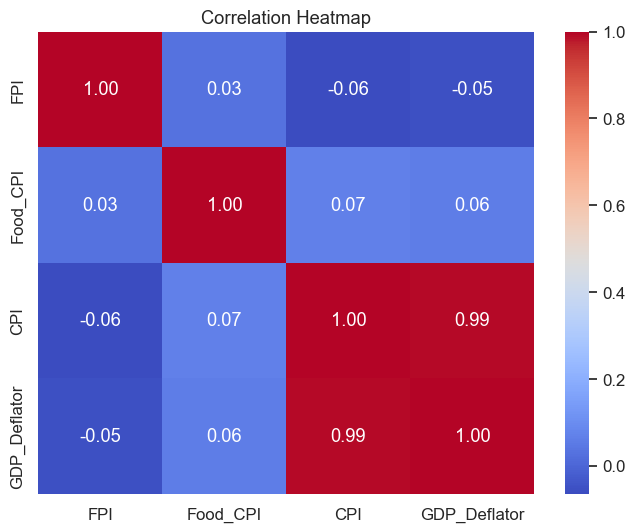

In [148]:
# 2. Heatmap of correlations

plt.figure(figsize=(8,6))
corr = eda_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Extreme Multicollinearity: The correlation of r=0.99 between the CPI and the GDP_Deflator indicates near-perfect multicollinearity.

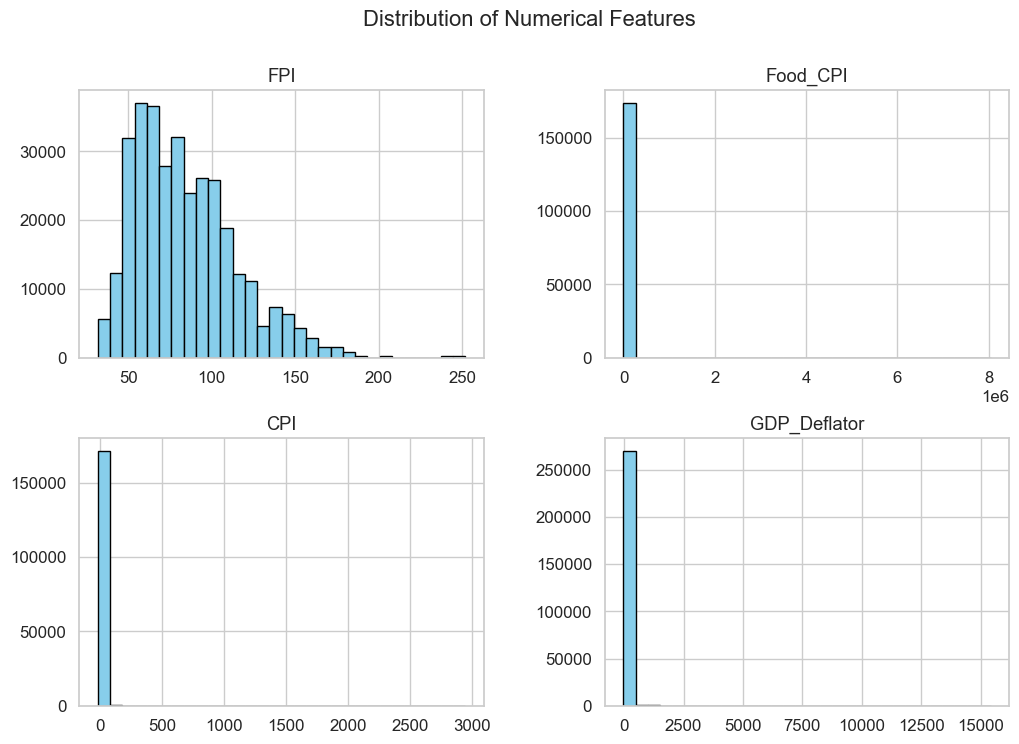

In [149]:
# 3. Histograms 

eda_df.hist(bins=30, figsize=(12,8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

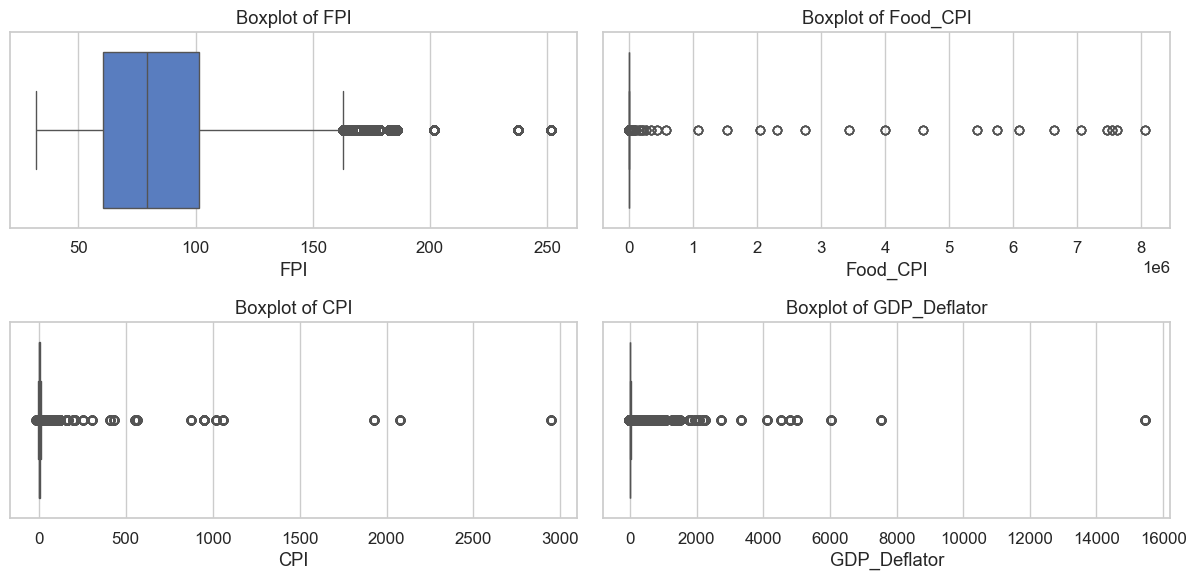

In [150]:

num_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x=merged[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

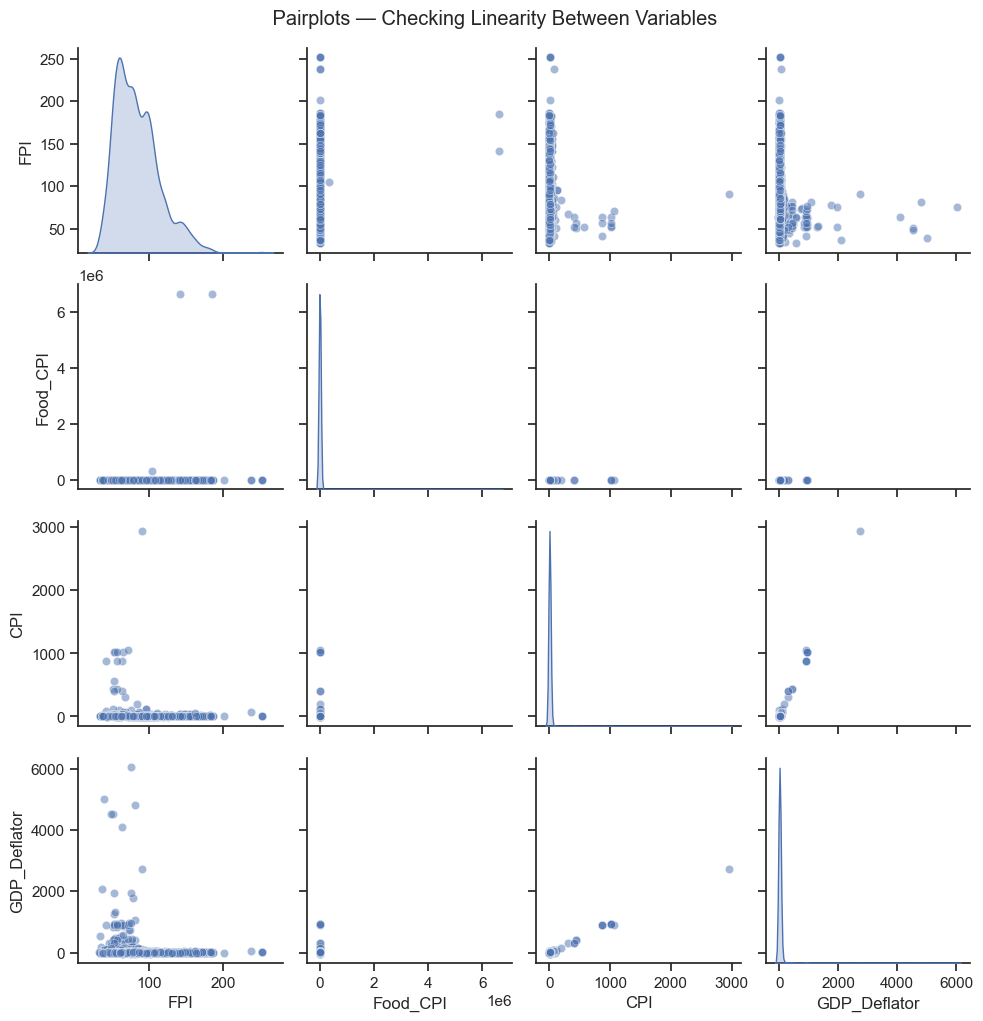

In [151]:
# Pairplot (scatterplots + histograms)
sample_df = eda_df.sample(n=5000, random_state=42)
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(10,8))
pair_plot = sns.pairplot(sample_df, diag_kind="kde", plot_kws={"alpha": 0.5})

pair_plot.fig.suptitle(" Pairplots — Checking Linearity Between Variables", y=1.02)
plt.show()

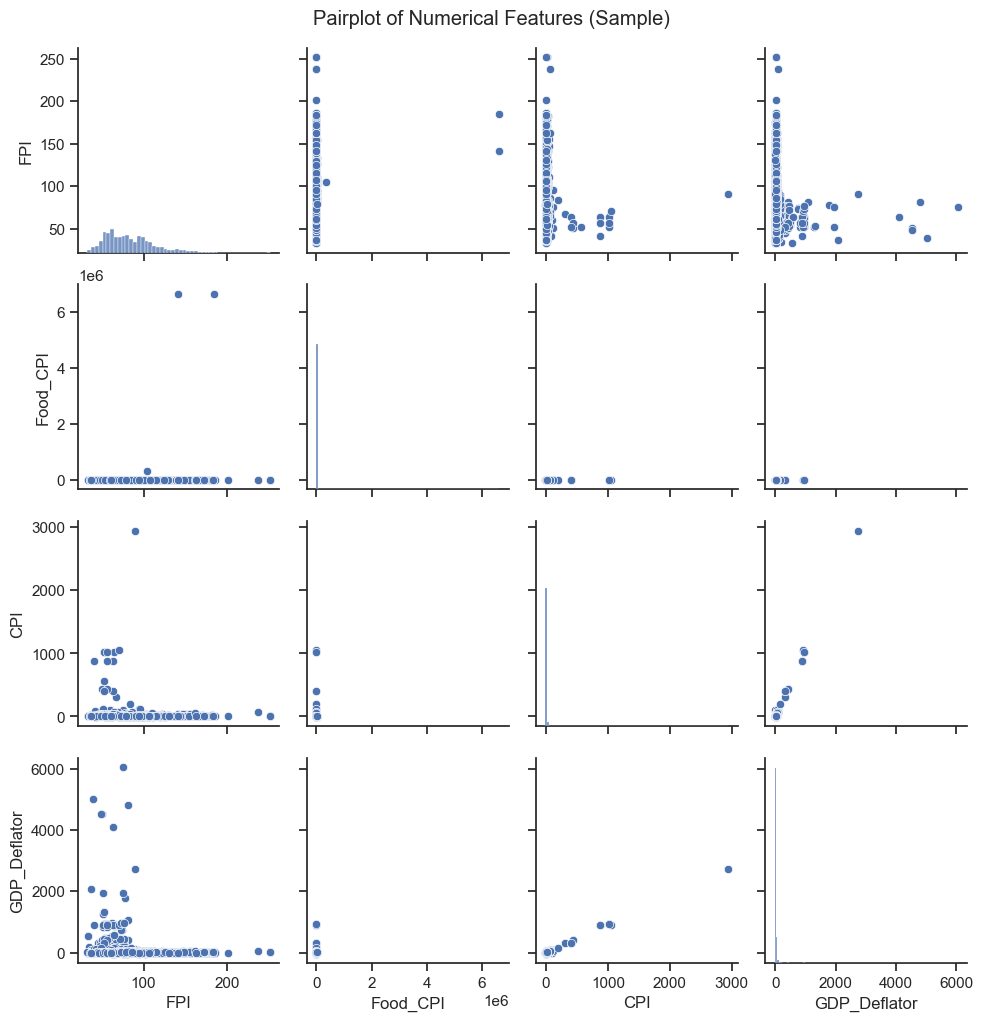

In [152]:
# 5. Pairplot (sample for performance)

sample_df = eda_df.sample(n=5000, random_state=42)  # sample to speed up plotting
sns.pairplot(sample_df)
plt.suptitle("Pairplot of Numerical Features (Sample)", y=1.02)
plt.show()

CPI vs. GDP_Deflator (Inferred from r=0.99)	Points lie tightly along a straight, upward line.	Highly Linear

FPI vs. CPI	Scattered vertically, no discernible straight line pattern.	Non-Linear

FPI vs. GDP_Deflator	Scattered vertically, no discernible straight line pattern.	Non-Linear

Food_CPI vs. All Others	Dominated by clustering near zero and extreme outliers.	Non-Linear

In [153]:


# Aggregate per year & commodity
agg = merged.groupby(['Year','Commodity']).agg({
    'FPI':'mean',
    'Food_CPI':'mean',
    'CPI':'mean'
}).reset_index()


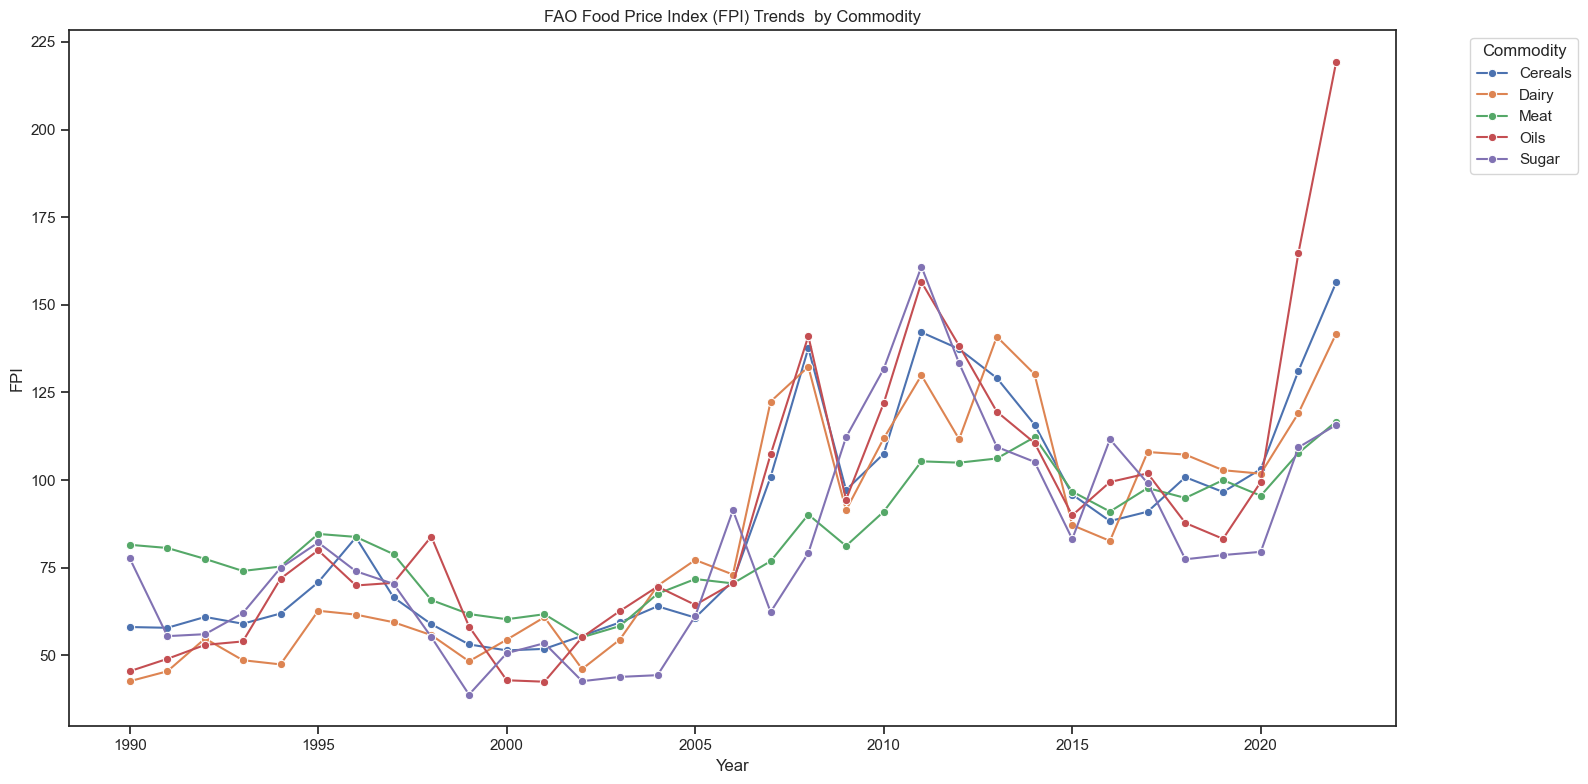

In [154]:
# Plot FPI trends per commodity
plt.figure(figsize=(16,8))
sns.lineplot(data=agg, x='Year', y='FPI', hue='Commodity', marker='o')
plt.title('FAO Food Price Index (FPI) Trends  by Commodity')
plt.ylabel('FPI')
plt.xlabel('Year')
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values

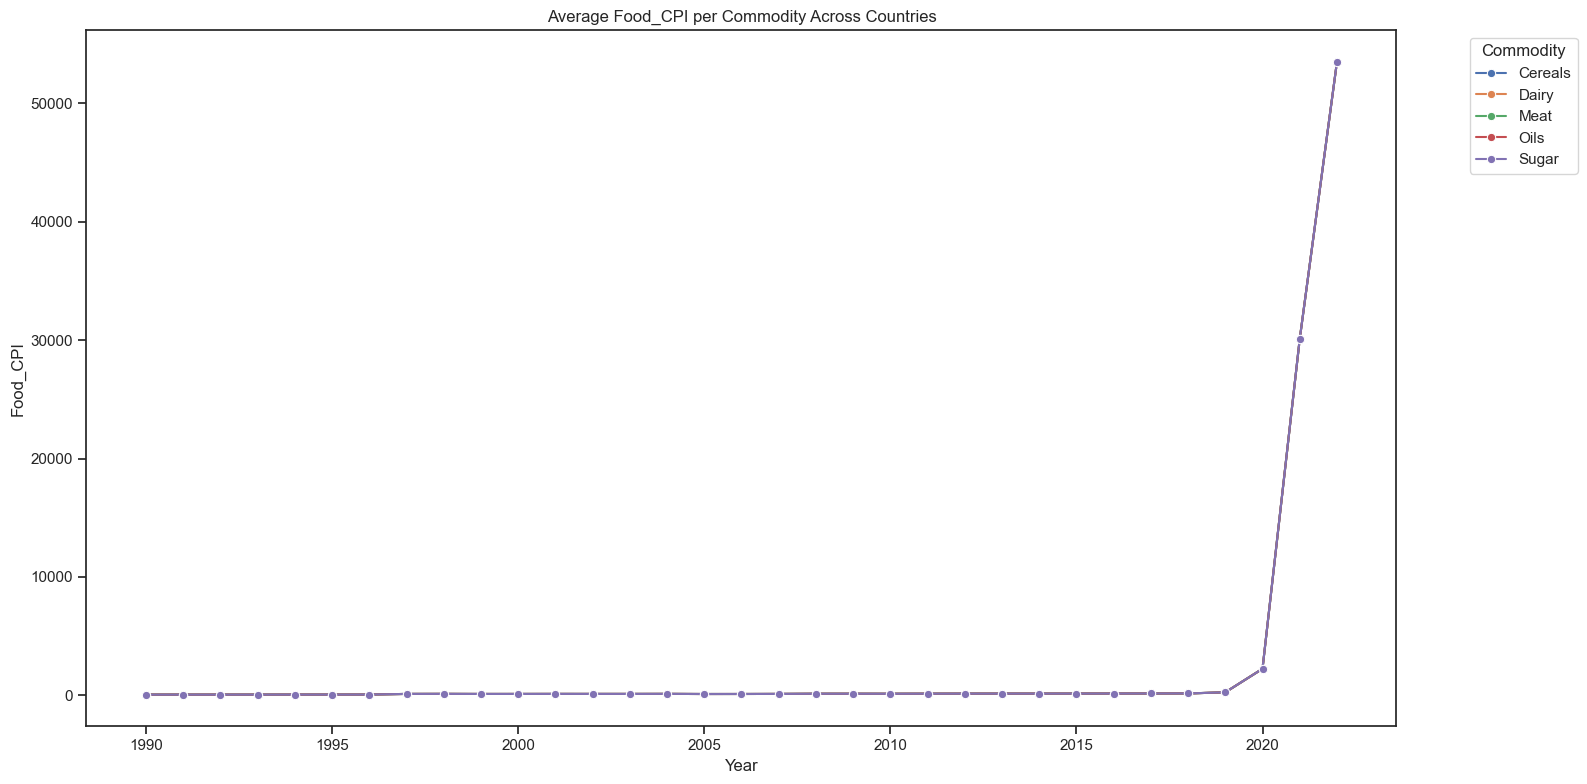

In [155]:
#  plot Food_CPI and CPI per commodity (only for countries with Food_CPI)
plt.figure(figsize=(16,8))
sns.lineplot(data=agg, x='Year', y='Food_CPI', hue='Commodity', marker='o')
plt.title('Average Food_CPI per Commodity Across Countries')
plt.ylabel('Food_CPI')
plt.xlabel('Year')
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


sudden acceleration of the average food consumer price index across countries, concentrated entirely in the period after 2020.

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values.

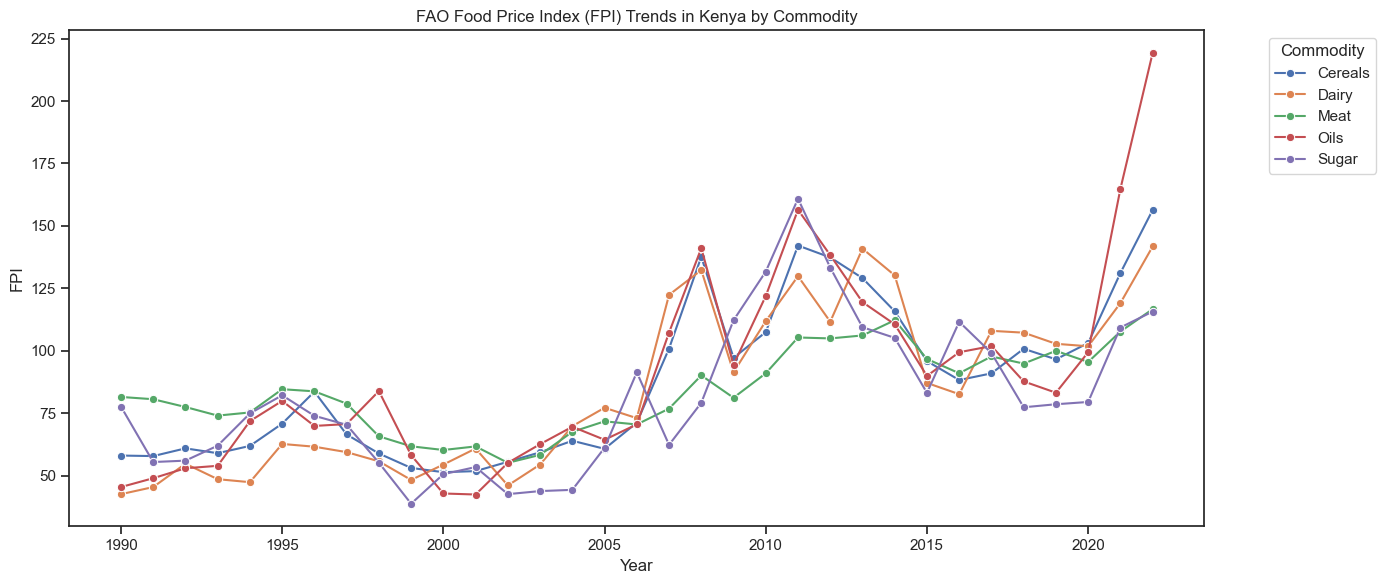

In [156]:
# Filter for Kenya
kenya_data = merged[merged['Country'] == 'Kenya']

# Aggregate by Year and Commodity for FPI
fpi_trends = kenya_data.groupby(['Year','Commodity'])['FPI'].mean().reset_index()

# Plot FPI trends
plt.figure(figsize=(14,6))
sns.lineplot(data=fpi_trends, x='Year', y='FPI', hue='Commodity', marker='o')
plt.title("FAO Food Price Index (FPI) Trends in Kenya by Commodity")
plt.xlabel("Year")
plt.ylabel("FPI")
plt.legend(title='Commodity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From 1990 to 2005, the FPI was stable and low, generally between 50 and 75.

A first major price spike occurred between 2007 and 2012, pushing most FPIs past 100.

Prices then remained volatile and higher (75-125) from 2012 until 2020.

A recent, dramatic surge began after 2020, driving several commodities to record high FPI values.

In [157]:
from statsmodels.tsa.stattools import adfuller

# Aggregate globally per year
global_fpi = merged.groupby('Year')['FPI'].mean().dropna()

# ADF Test
adf_result = adfuller(global_fpi)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("Result: Data is likely stationary ")
else:
    print("Result: Data is likely non-stationary ")


ADF Statistic: 0.8940383966365595
p-value: 0.9930120305137831
Critical Values: {'1%': np.float64(-3.7529275211638033), '5%': np.float64(-2.998499866852963), '10%': np.float64(-2.6389669754253307)}
Result: Data is likely non-stationary 


In [158]:
# Check how many years we have
n_points = len(global_fpi)
max_lags = n_points // 2  # 50% of available points

print(f"Number of years: {n_points}, using max lags = {max_lags}")

Number of years: 33, using max lags = 16


<Figure size 1200x400 with 0 Axes>

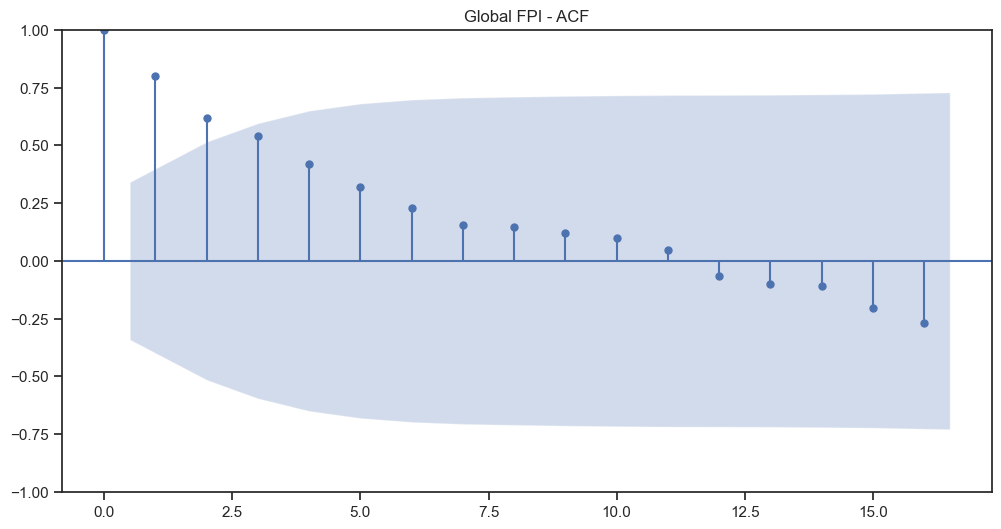

<Figure size 1200x400 with 0 Axes>

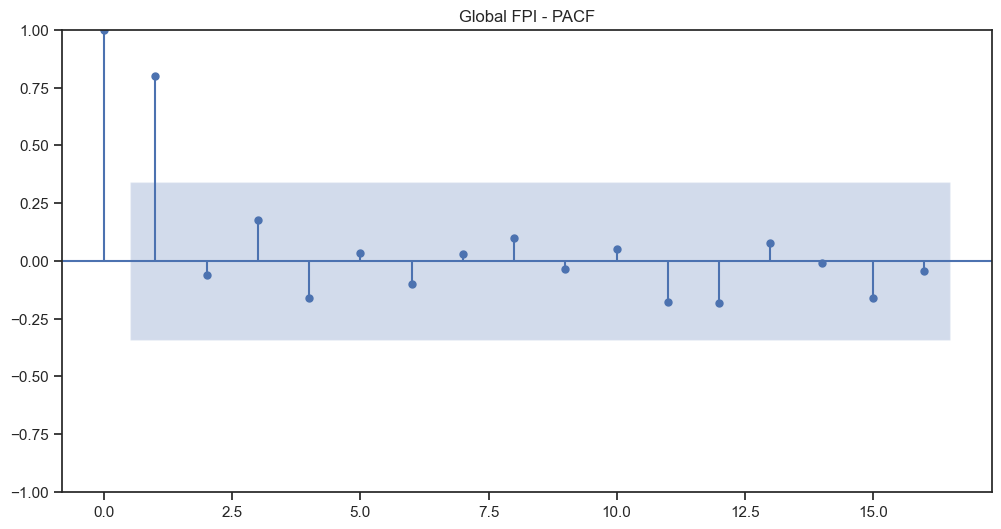

In [159]:
# ACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plot_acf(global_fpi, lags=max_lags)
plt.title("Global FPI - ACF")
plt.show()

# PACF plot
plt.figure(figsize=(12,4))
plot_pacf(global_fpi, lags=max_lags, method='ywm')
plt.title("Global FPI - PACF")
plt.show()

The ACF plot indicates that the Global Food Price Index is highly correlated with its own past values, showing strong persistence and likely the presence of a long-term trend.
The clear and decisive cut-off after Lag 1 suggests that the time series has an underlying Autoregressive process of order1
The positive correlation slowly decays as the lag increases, remaining positive and statistically significant up to approximately lag 12. This long, slow decay of the autocorrelation is a classic indicator of a non-stationary time series

# Preprocessing

In [160]:
# Check missing values
missing = merged.isna().sum().sort_values(ascending=False)
missing_percent = (merged.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing Values': missing,
    'Missing %': missing_percent
})
print("Missing values summary:")
print(missing_summary)


Missing values summary:
              Missing Values  Missing %
CPI                   158840      47.88
Commodity                  0       0.00
Country                    0       0.00
Date                       0       0.00
FPI                        0       0.00
Food_CPI              157550      47.49
GDP_Deflator           59260      17.86
Month                      0       0.00
Year                       0       0.00


In [161]:
# Check and remove duplicates
print("Duplicate rows before:", merged.duplicated().sum())
merged = merged.drop_duplicates()
print("Duplicate rows after:", merged.duplicated().sum())


Duplicate rows before: 32980
Duplicate rows after: 0


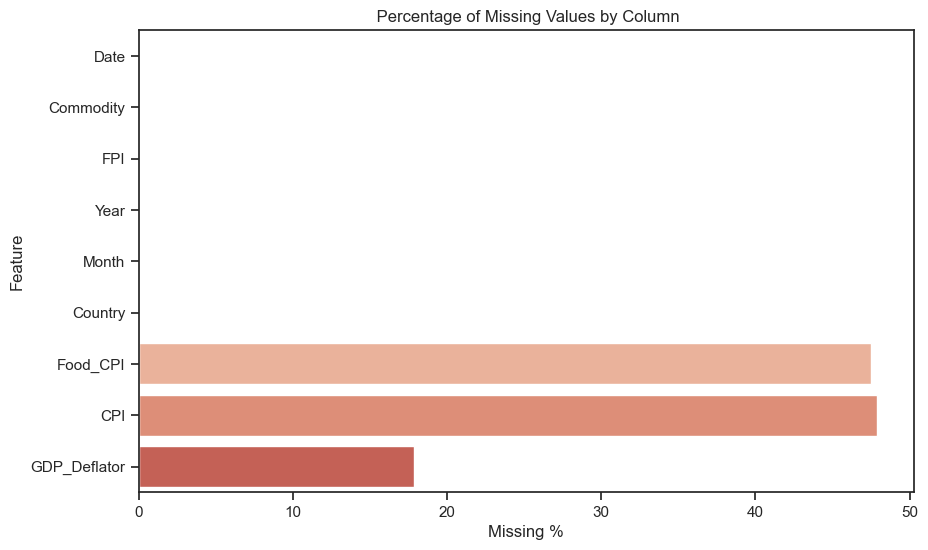

In [162]:


#  Bar Plot of Missingness ---
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent, y=missing_percent.index, palette="coolwarm")
plt.title(" Percentage of Missing Values by Column")
plt.xlabel("Missing %")
plt.ylabel("Feature")
plt.show()

In [163]:
# CPI and GDP_Deflator have r ~ 0.99 => drop GDP_Deflator
merged.drop(columns=['GDP_Deflator'], inplace=True)

In [164]:
#  Drop Year and Month columns 
merged.drop(columns=['Year', 'Month'], inplace=True, errors='ignore')

In [165]:
merged['Food_CPI'] = merged.groupby('Country')['Food_CPI'].transform(lambda x: x.interpolate(method='linear'))
merged['CPI'] = merged.groupby('Country')['CPI'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [166]:
# Set Date as index
merged['Date'] = pd.to_datetime(merged['Date'])
merged.set_index('Date', inplace=True) 
merged.sort_index(inplace=True)  #ensures dates go from oldest → newest

In [167]:
merged.isnull().sum()

Commodity        0
FPI              0
Country          0
Food_CPI     38217
CPI          21340
dtype: int64

In [168]:
merged.isna().sum()


Commodity        0
FPI              0
Country          0
Food_CPI     38217
CPI          21340
dtype: int64

In [169]:
# Fill numeric missing values
for col in ['Food_CPI', 'CPI']:
    merged[col] = merged[col].interpolate().ffill().bfill()

In [170]:
merged.isna().sum()

Commodity    0
FPI          0
Country      0
Food_CPI     0
CPI          0
dtype: int64

In [171]:
merged.isna().sum()

Commodity    0
FPI          0
Country      0
Food_CPI     0
CPI          0
dtype: int64

In [172]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298760 entries, 1990-01-01 to 2022-04-01
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Commodity  298760 non-null  object 
 1   FPI        298760 non-null  float64
 2   Country    298760 non-null  object 
 3   Food_CPI   298760 non-null  float64
 4   CPI        298760 non-null  float64
dtypes: float64(3), object(2)
memory usage: 13.7+ MB


In [173]:
merged.isnull().sum()

Commodity    0
FPI          0
Country      0
Food_CPI     0
CPI          0
dtype: int64

In [174]:
merged.head()

,Commodity,FPI,Country,Food_CPI,CPI
Date,,,,,
1990-01-01,Meat,73.374551,Austria,59.465810,3.261872
1990-01-01,Cereals,64.140607,Tunisia,149.099763,8.306461
1990-01-01,Cereals,64.140607,Ukraine,327.246409,20.183637
1990-01-01,Cereals,64.140607,Vietnam,109.699791,15.588420
1990-01-01,Cereals,64.140607,Zambia,379.509887,10.993204


In [175]:
merged.tail()

,Commodity,FPI,Country,Food_CPI,CPI
Date,,,,,
2022-04-01,Meat,121.919791,Russian Federation,153.5286,6.694459
2022-04-01,Meat,121.919791,Singapore,90.3930,6.130954
2022-04-01,Meat,121.919791,Sri Lanka,180.9000,49.721102
2022-04-01,Meat,121.919791,Myanmar,206.8000,8.825067
2022-04-01,Sugar,121.791250,,206.8000,8.825067


In [176]:
merged.isna().sum()

Commodity    0
FPI          0
Country      0
Food_CPI     0
CPI          0
dtype: int64

In [177]:
#  Handle Outliers (Capping using IQR method)

numerical_cols = ['FPI', 'Food_CPI', 'CPI', 'GDP_Deflator']

def cap_outliers(merged, cols):
    outlier_summary = {}

    for col in cols:
        if col not in merged.columns:
            print(f" Skipping '{col}' — not found in DataFrame")
            continue

        Q1 = merged[col].quantile(0.25)
        Q3 = merged[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        below = (merged[col] < lower_bound).sum()
        above = (merged[col] > upper_bound).sum()

        merged[col] = np.where(
            merged[col] < lower_bound, lower_bound,
            np.where(merged[col] > upper_bound, upper_bound, merged[col])
        )

        outlier_summary[col] = {
            "Lower Bound": round(lower_bound, 2),
            "Upper Bound": round(upper_bound, 2),
            "Capped Below": int(below),
            "Capped Above": int(above)
        }

        print(f" {col}: capped {below} below and {above} above the bounds")

    return pd.DataFrame(outlier_summary).T



Encoding

In [178]:
from sklearn.preprocessing import LabelEncoder

# Label encode Commodity and Country
for col in ['Commodity', 'Country']:
    le = LabelEncoder()
    merged[col] = le.fit_transform(merged[col])


In [179]:
# Lag Features 
lags = [1, 3, 6, 12]
for lag in lags:
    merged[f'FPI_lag{lag}'] = merged['FPI'].shift(lag)
    merged[f'Food_CPI_lag{lag}'] = merged['Food_CPI'].shift(lag)

. Lag Features

A lag feature is simply the previous value(s) of a variable.

Why useful:

Helps forecast future values by showing how past values influence the present.

For example, this month’s Food_CPI may be related to last month’s Food_CPI.

In [180]:
#  Rolling Features 
windows = [3, 6, 12]
for window in windows:
    merged[f'FPI_roll_mean_{window}'] = merged['FPI'].rolling(window=window).mean()
    merged[f'FPI_roll_std_{window}'] = merged['FPI'].rolling(window=window).std()
    merged[f'Food_CPI_roll_mean_{window}'] = merged['Food_CPI'].rolling(window=window).mean()
    merged[f'Food_CPI_roll_std_{window}'] = merged['Food_CPI'].rolling(window=window).std()

. Rolling / Moving Average

Smooths out short-term fluctuations in volatile data like food prices.

Makes it easier to see overall trends, not just random spikes.

roll3 → short-term trend (3 months)

roll12 → yearly/seasonal trend (12 months)

In [181]:
# Drop NaNs caused by lags/rolling
merged = merged.dropna()

In [182]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298748 entries, 1990-01-01 to 2022-04-01
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Commodity              298748 non-null  int64  
 1   FPI                    298748 non-null  float64
 2   Country                298748 non-null  int64  
 3   Food_CPI               298748 non-null  float64
 4   CPI                    298748 non-null  float64
 5   FPI_lag1               298748 non-null  float64
 6   Food_CPI_lag1          298748 non-null  float64
 7   FPI_lag3               298748 non-null  float64
 8   Food_CPI_lag3          298748 non-null  float64
 9   FPI_lag6               298748 non-null  float64
 10  Food_CPI_lag6          298748 non-null  float64
 11  FPI_lag12              298748 non-null  float64
 12  Food_CPI_lag12         298748 non-null  float64
 13  FPI_roll_mean_3        298748 non-null  float64
 14  FPI_roll_std_3      

In [183]:
merged.isnull().sum()

Commodity                0
FPI                      0
Country                  0
Food_CPI                 0
CPI                      0
FPI_lag1                 0
Food_CPI_lag1            0
FPI_lag3                 0
Food_CPI_lag3            0
FPI_lag6                 0
Food_CPI_lag6            0
FPI_lag12                0
Food_CPI_lag12           0
FPI_roll_mean_3          0
FPI_roll_std_3           0
Food_CPI_roll_mean_3     0
Food_CPI_roll_std_3      0
FPI_roll_mean_6          0
FPI_roll_std_6           0
Food_CPI_roll_mean_6     0
Food_CPI_roll_std_6      0
FPI_roll_mean_12         0
FPI_roll_std_12          0
Food_CPI_roll_mean_12    0
Food_CPI_roll_std_12     0
dtype: int64

In [184]:
merged.shape

(298748, 25)

In [185]:
merged.head()

,Commodity,FPI,Country,Food_CPI,CPI,FPI_lag1,Food_CPI_lag1,FPI_lag3,Food_CPI_lag3,FPI_lag6,...,Food_CPI_roll_mean_3,Food_CPI_roll_std_3,FPI_roll_mean_6,FPI_roll_std_6,Food_CPI_roll_mean_6,Food_CPI_roll_std_6,FPI_roll_mean_12,FPI_roll_std_12,Food_CPI_roll_mean_12,Food_CPI_roll_std_12
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,0,64.140607,140,119.240481,5.828386,53.503031,119.240481,53.503031,327.246409,53.503031,...,129.193575,17.239265,55.27596,4.342772,200.672802,120.168127,58.821819,5.555293,244.051036,125.236755
1990-01-01,1,53.503031,139,135.083530,7.967574,64.140607,119.240481,53.503031,149.099763,53.503031,...,124.521497,9.146988,55.27596,4.342772,159.935076,83.142973,57.935354,5.477593,242.883017,126.263971
1990-01-01,1,53.503031,127,49.494000,6.130954,53.503031,135.083530,53.503031,119.240481,53.503031,...,101.272670,45.535959,55.27596,4.342772,149.900777,93.416587,57.048889,5.237581,219.736983,134.577372
1990-01-01,1,53.503031,126,116.833561,27.208288,53.503031,49.494000,64.140607,119.240481,53.503031,...,100.470364,45.080013,55.27596,4.342772,114.831969,34.340454,56.162425,4.811025,220.331464,134.061874
1990-01-01,1,53.503031,125,117.330312,2.626036,53.503031,116.833561,53.503031,135.083530,53.503031,...,94.552624,39.022704,55.27596,4.342772,109.537061,30.199595,55.275960,4.140671,198.483166,126.936540


In [186]:
merged.tail()

,Commodity,FPI,Country,Food_CPI,CPI,FPI_lag1,Food_CPI_lag1,FPI_lag3,Food_CPI_lag3,FPI_lag6,...,Food_CPI_roll_mean_3,Food_CPI_roll_std_3,FPI_roll_mean_6,FPI_roll_std_6,Food_CPI_roll_mean_6,Food_CPI_roll_std_6,FPI_roll_mean_12,FPI_roll_std_12,Food_CPI_roll_mean_12,Food_CPI_roll_std_12
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,2,121.919791,119,153.5286,6.694459,121.919791,136.9310,121.919791,112.5000,121.919791,...,138.391700,14.463510,121.919791,0.000000,125.430483,17.533724,121.919791,0.000000,127.015492,22.606617
2022-04-01,2,121.919791,127,90.3930,6.130954,121.919791,153.5286,121.919791,124.7155,121.919791,...,126.950867,32.730299,121.919791,0.000000,120.512650,22.755597,121.919791,0.000000,120.089908,19.601678
2022-04-01,2,121.919791,132,180.9000,49.721102,121.919791,90.3930,121.919791,136.9310,121.919791,...,141.607200,46.416735,121.919791,0.000000,133.161350,31.734460,121.919791,0.000000,126.878242,25.126868
2022-04-01,2,121.919791,99,206.8000,8.825067,121.919791,180.9000,121.919791,153.5286,121.919791,...,159.364333,61.118985,121.919791,0.000000,148.878017,41.349867,121.919791,0.000000,133.411575,34.135975
2022-04-01,4,121.791250,0,206.8000,8.825067,121.919791,206.8000,121.919791,90.3930,121.919791,...,198.166667,14.954850,121.898367,0.052477,162.558767,45.160179,121.909079,0.037107,138.957408,40.212995


###  Features and target

In [187]:
# Features and target
X = merged.drop('FPI', axis=1)
y = merged['FPI']

### Train Test split

In [188]:

# Determine chronological split by date
all_dates = merged.index.sort_values().unique()
split_point = int(len(all_dates) * 0.8)
train_dates = all_dates[:split_point]
test_dates  = all_dates[split_point:]

In [189]:

# Boolean masks for train/test
train_mask = merged.index.isin(train_dates)
test_mask  = merged.index.isin(test_dates)

In [190]:
# Create train/test sets
X_train = X.loc[train_mask]
y_train = y.loc[train_mask]

X_test = X.loc[test_mask]
y_test = y.loc[test_mask]

In [191]:
print(f"Training period: {train_dates[0].date()} → {train_dates[-1].date()}")
print(f"Testing  period: {test_dates[0].date()} → {test_dates[-1].date()}")
print("Train shape:", X_train.shape)
print("Test  shape:", X_test.shape)

Training period: 1990-01-01 → 2015-10-01
Testing  period: 2015-11-01 → 2022-04-01
Train shape: (238688, 24)
Test  shape: (60060, 24)


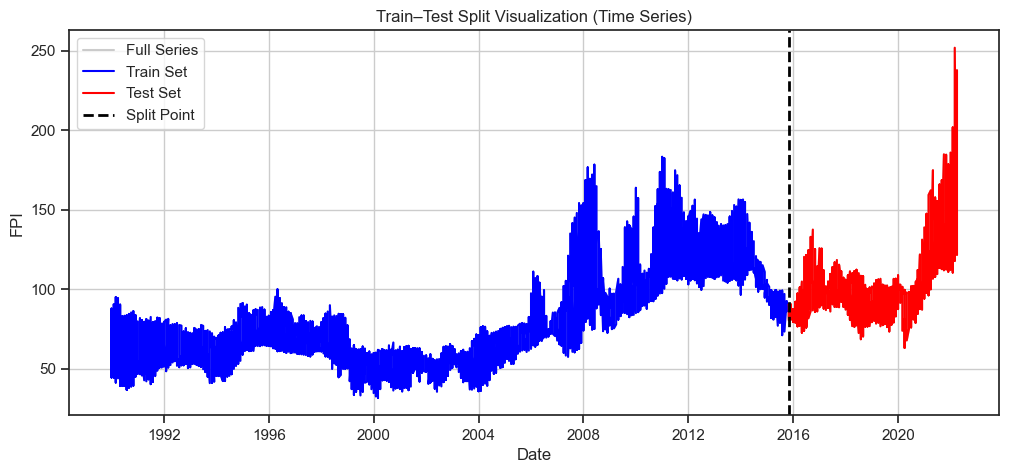

In [192]:
#  Visualize 
plt.figure(figsize=(12,5))
plt.plot(merged.index, merged['FPI'], label='Full Series', color='gray', alpha=0.4)
plt.plot(y_train.index, y_train, label='Train Set', color='blue')
plt.plot(y_test.index, y_test, label='Test Set', color='red')
plt.axvline(x=test_dates[0], color='black', linestyle='--', lw=2, label='Split Point')
plt.title("Train–Test Split Visualization (Time Series)")
plt.xlabel("Date")
plt.ylabel("FPI")
plt.legend()
plt.grid(True)
plt.show()

In [193]:
# Use StandardScaler for regression
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [194]:
#  Train ML Models

from sklearn.linear_model import LinearRegression, Ridge

# Dictionary to store trained models
trained_models = {}

#  Linear Regression 
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
trained_models['Linear Regression'] = lr_model

#  Ridge Regression 
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
trained_models['Ridge Regression'] = ridge_model

#  Random Forest 
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
trained_models['Random Forest'] = rf_model

#  Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)
trained_models['Gradient Boosting'] = gb_model

In [195]:
#  Evaluate Models

results = {}

for name, model in trained_models.items():
    print(f"\nEvaluating {name}...")
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Testing metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        "Train RMSE": train_rmse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }

# Convert results into a DataFrame
results_df = pd.DataFrame(results).T
display(results_df)


Evaluating Linear Regression...

Evaluating Ridge Regression...

Evaluating Random Forest...

Evaluating Gradient Boosting...


,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
Linear Regression,2.394809,0.540855,0.993684,3.063464,0.676339,0.981981
Ridge Regression,2.394818,0.540752,0.993683,3.063463,0.676167,0.981981
Random Forest,1.565003,0.424680,0.997302,5.909568,1.239474,0.932947
Gradient Boosting,2.032378,0.548937,0.995451,5.463211,1.133797,0.942694


Feature Importance

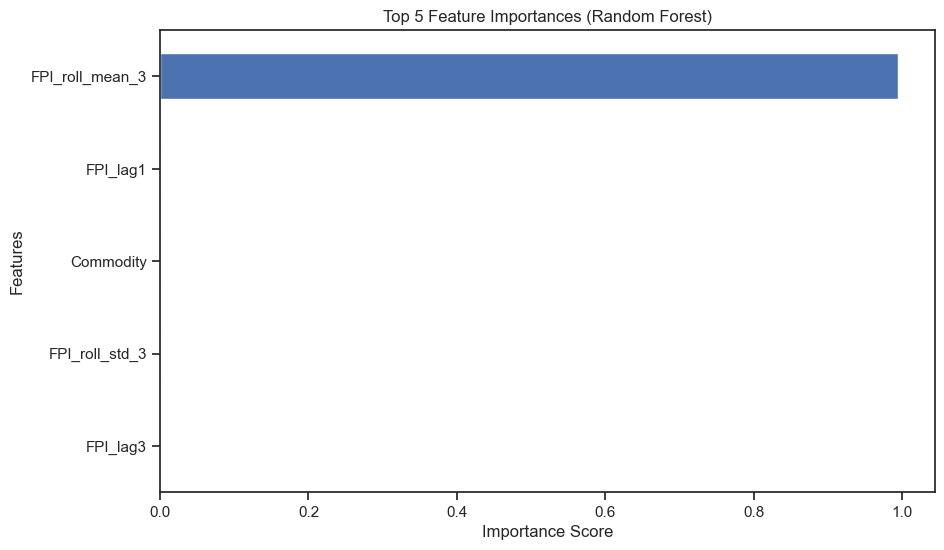

In [196]:
importances = rf_model.feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(5).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 5 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


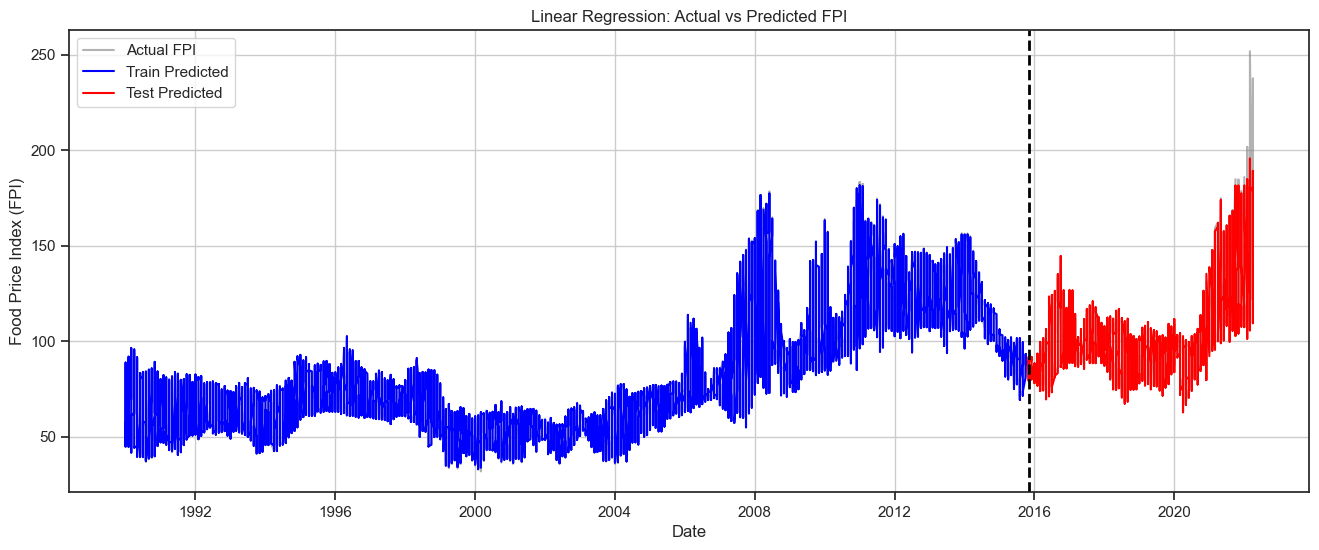

In [197]:
# Create a DataFrame for predictions using only X_train and X_test indices
pred_df = pd.DataFrame(index=X_train.index.append(X_test.index))
pred_df['FPI_Actual'] = pd.concat([y_train, y_test])

# Add predicted values
pred_df['FPI_Predicted'] = pd.Series(np.concatenate([y_train_pred, y_test_pred]), index=pred_df.index)

# Plot
plt.figure(figsize=(16,6))
plt.plot(pred_df.index, pred_df['FPI_Actual'], label='Actual FPI', color='gray', alpha=0.6)
plt.plot(pred_df.index[:len(X_train)], pred_df['FPI_Predicted'][:len(X_train)], label='Train Predicted', color='blue')
plt.plot(pred_df.index[len(X_train):], pred_df['FPI_Predicted'][len(X_train):], label='Test Predicted', color='red')

# Add split marker
plt.axvline(x=X_test.index.min(), color='black', linestyle='--', lw=2)

plt.title("Linear Regression: Actual vs Predicted FPI")
plt.xlabel("Date")
plt.ylabel("Food Price Index (FPI)")
plt.legend()
plt.grid(True)
plt.show()


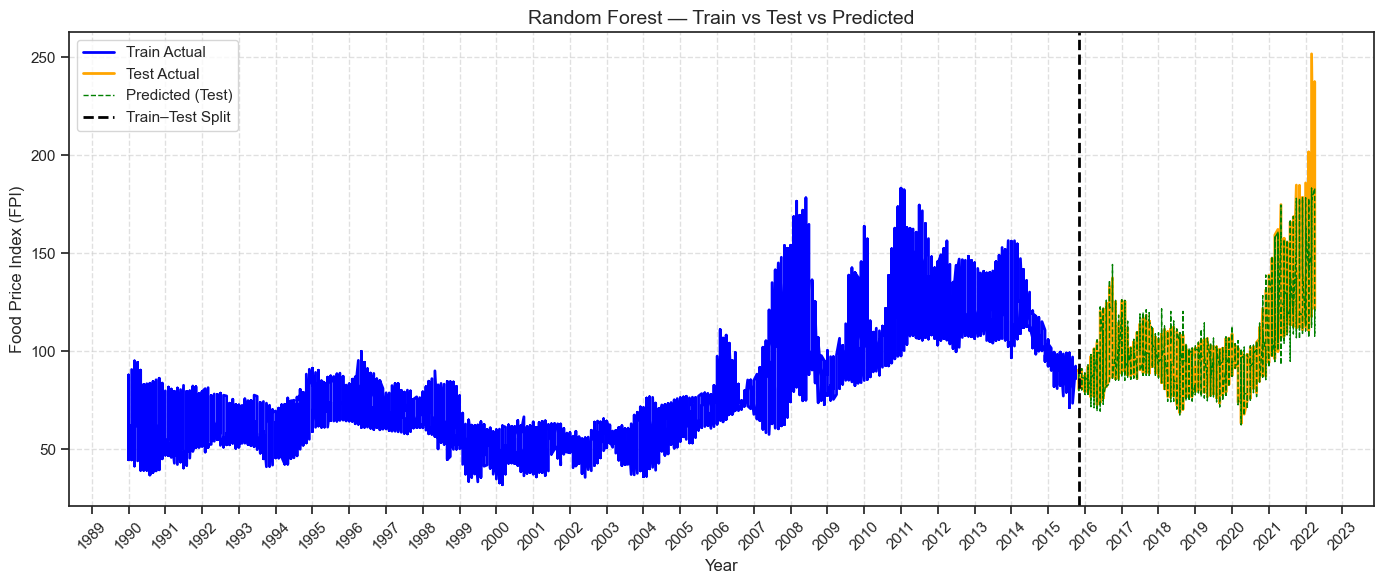

In [198]:

#  Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

#  Dates (assumes X has a datetime index )
dates_train = X_train.index
dates_test = X_test.index

#  Combine actual and predicted into one DataFrame
results_rf = pd.DataFrame({
    'Date': list(dates_train) + list(dates_test),
    'Actual FPI': np.concatenate([y_train, y_test])
})
results_rf['Type'] = ['Train'] * len(dates_train) + ['Test'] * len(dates_test)
results_rf['Predicted FPI'] = [None] * len(dates_train) + list(y_test_pred_rf.flatten())

#  Plot
plt.figure(figsize=(14, 6))
plt.plot(results_rf.loc[results_rf['Type'] == 'Train', 'Date'],
         results_rf.loc[results_rf['Type'] == 'Train', 'Actual FPI'],
         label='Train Actual', color='blue', linewidth=2)

plt.plot(results_rf.loc[results_rf['Type'] == 'Test', 'Date'],
         results_rf.loc[results_rf['Type'] == 'Test', 'Actual FPI'],
         label='Test Actual', color='orange', linewidth=2)

plt.plot(results_rf.loc[results_rf['Type'] == 'Test', 'Date'],
         results_rf.loc[results_rf['Type'] == 'Test', 'Predicted FPI'],
         label='Predicted (Test)', color='green', linestyle='--', linewidth=1.0)

# Vertical split line
plt.axvline(x=dates_test[0], color='black', linestyle='--', lw=2, label='Train–Test Split')

#  Titles and formatting
plt.title("Random Forest — Train vs Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

#  Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


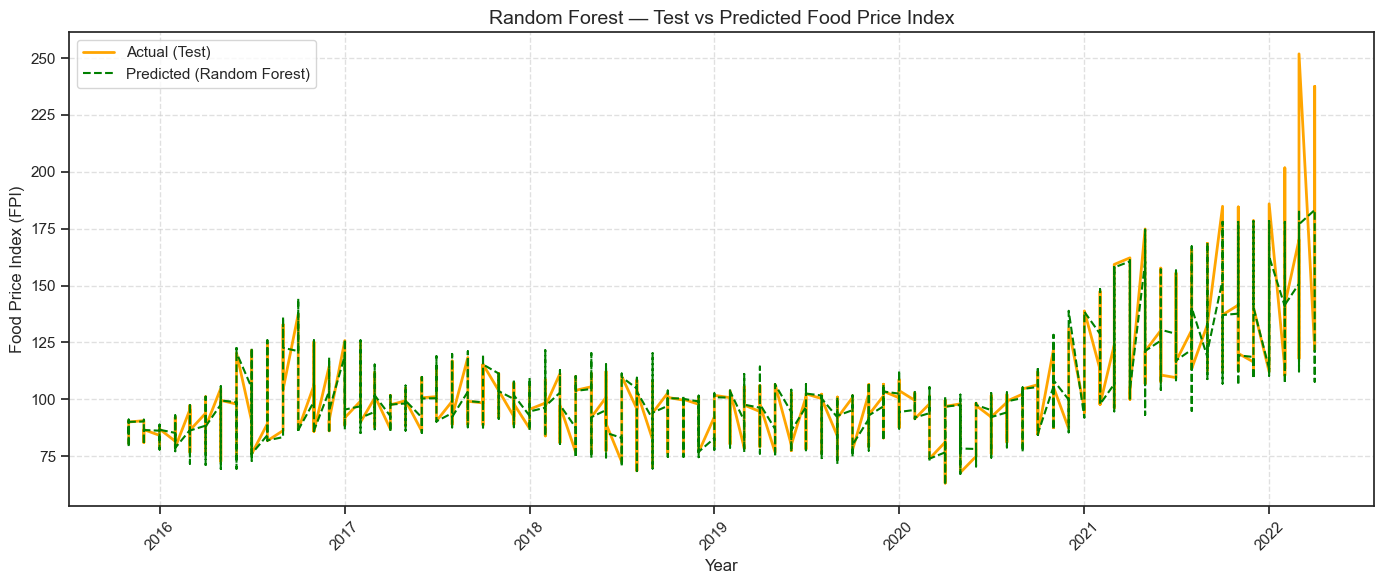

In [199]:
#  Predictions
y_test_pred_rf = rf_model.predict(X_test_scaled)

#  Dates (assumes X has a datetime index or 'Date' column)
dates_test = X_test.index

#  Combine actual and predicted for the test set only
results_rf_test = pd.DataFrame({
    'Date': dates_test,
    'Actual FPI': y_test,
    'Predicted FPI': y_test_pred_rf
})

#  Plot Test vs Predicted
plt.figure(figsize=(14, 6))

plt.plot(results_rf_test['Date'], results_rf_test['Actual FPI'],
         label='Actual (Test)', color='orange', linewidth=2)

plt.plot(results_rf_test['Date'], results_rf_test['Predicted FPI'],
         label='Predicted (Random Forest)', color='green', linestyle='--', linewidth=1.5)

#  Titles and formatting
plt.title("Random Forest — Test vs Predicted Food Price Index", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

#  Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series Models

<Axes: xlabel='Date'>

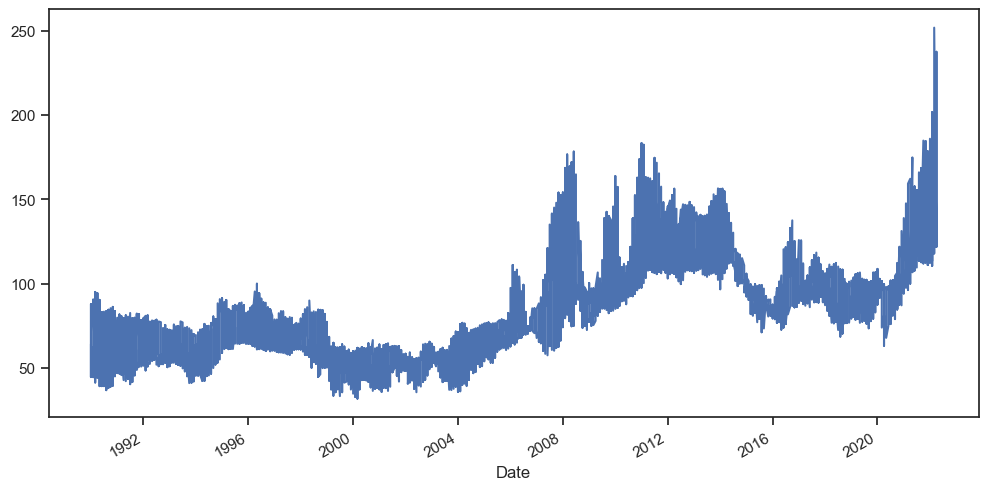

In [200]:
merged['FPI'].plot()


In [201]:
# Use same X_train_scaled, X_test_scaled, y_train, y_test from ML
X_train_exog = X_train_scaled
X_test_exog = X_test_scaled
y_train_exog = y_train
y_test_exog = y_test

In [202]:
print("Features & target shapes:")
print("X_train:", X_train_exog.shape, "X_test:", X_test_exog.shape)
print("y_train:", y_train_exog.shape, "y_test:", y_test_exog.shape)

Features & target shapes:
X_train: (238688, 24) X_test: (60060, 24)
y_train: (238688,) y_test: (60060,)


# ARIMAX Model

In [203]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMAX
arimax_model = ARIMA(
    endog=y_train_exog,
    exog=X_train_exog,
    order=(1,1,0)
)
arimax_fit = arimax_model.fit()

In [204]:
# Predictions
y_train_pred_arimax = arimax_fit.predict(start=0, end=len(y_train_exog)-1, exog=X_train_exog)
y_test_pred_arimax = arimax_fit.predict(start=len(y_train_exog), end=len(y_train_exog)+len(y_test_exog)-1, exog=X_test_exog)

In [205]:
# Metrics
train_rmse_arimax = np.sqrt(mean_squared_error(y_train_exog, y_train_pred_arimax))
train_mae_arimax = mean_absolute_error(y_train_exog, y_train_pred_arimax)
train_r2_arimax = r2_score(y_train_exog, y_train_pred_arimax)

test_rmse_arimax = np.sqrt(mean_squared_error(y_test_exog, y_test_pred_arimax))
test_mae_arimax = mean_absolute_error(y_test_exog, y_test_pred_arimax)
test_r2_arimax = r2_score(y_test_exog, y_test_pred_arimax)

# SARIMAX (Seasonal)

In [206]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    endog=y_train_exog,
    exog=X_train_exog,
    order=(1,1,0),          # non-seasonal from ARIMA rationale
    seasonal_order=(1,1,1,12), # seasonal: P=1, D=1, Q=1, s=12
    enforce_stationarity=False,
    enforce_invertibility=False,
    method='lbfgs'
)
sarimax_fit = sarimax_model.fit(disp=False)

In [207]:
# Predictions
y_train_pred_sarimax = sarimax_fit.predict(start=0, end=len(y_train_exog)-1, exog=X_train_exog)
y_test_pred_sarimax = sarimax_fit.predict(start=len(y_train_exog), end=len(y_train_exog)+len(y_test_exog)-1, exog=X_test_exog)

In [208]:
# Metrics
train_rmse_sarimax = np.sqrt(mean_squared_error(y_train_exog, y_train_pred_sarimax))
train_mae_sarimax = mean_absolute_error(y_train_exog, y_train_pred_sarimax)
train_r2_sarimax = r2_score(y_train_exog, y_train_pred_sarimax)

test_rmse_sarimax = np.sqrt(mean_squared_error(y_test_exog, y_test_pred_sarimax))
test_mae_sarimax = mean_absolute_error(y_test_exog, y_test_pred_sarimax)
test_r2_sarimax = r2_score(y_test_exog, y_test_pred_sarimax)

In [210]:
ts_results = {
    "ARIMAX": {
        "Train RMSE": train_rmse_arimax,
        "Train MAE": train_mae_arimax,
        "Train R2": train_r2_arimax,
        "Test RMSE": test_rmse_arimax,
        "Test MAE": test_mae_arimax,
        "Test R2": test_r2_arimax
    },
    "SARIMAX": {
        "Train RMSE": train_rmse_sarimax,
        "Train MAE": train_mae_sarimax,
        "Train R2": train_r2_sarimax,
        "Test RMSE": test_rmse_sarimax,
        "Test MAE": test_mae_sarimax,
        "Test R2": test_r2_sarimax
    }
}

ts_results_df = pd.DataFrame(ts_results).T
display(ts_results_df)


,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
ARIMAX,2.997925,0.698031,0.990101,16.716830,11.049687,0.463447
SARIMAX,3.024258,0.716610,0.989927,6.201006,3.857726,0.926171


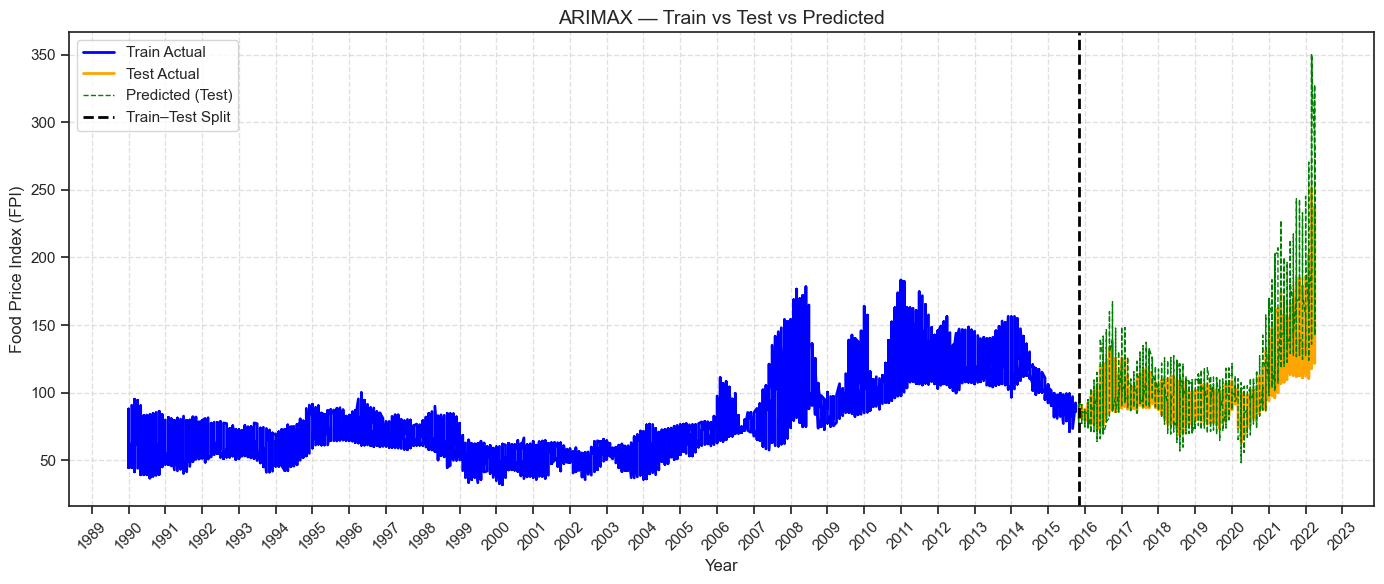

In [212]:

# Ensure Series shape consistency
y_train_pred_arimax = np.array(y_train_pred_arimax).reshape(-1)
y_test_pred_arimax = np.array(y_test_pred_arimax).reshape(-1)

# Combine into DataFrame (same as Random Forest structure)
results_arimax = pd.DataFrame({
    'Date': list(dates_train) + list(dates_test),
    'Actual FPI': np.concatenate([y_train_exog, y_test_exog])
})
results_arimax['Type'] = ['Train'] * len(dates_train) + ['Test'] * len(dates_test)
results_arimax['Predicted FPI'] = [None] * len(dates_train) + list(y_test_pred_arimax)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_arimax.loc[results_arimax['Type'] == 'Train', 'Date'],
         results_arimax.loc[results_arimax['Type'] == 'Train', 'Actual FPI'],
         label='Train Actual', color='blue', linewidth=2)

plt.plot(results_arimax.loc[results_arimax['Type'] == 'Test', 'Date'],
         results_arimax.loc[results_arimax['Type'] == 'Test', 'Actual FPI'],
         label='Test Actual', color='orange', linewidth=2)

plt.plot(results_arimax.loc[results_arimax['Type'] == 'Test', 'Date'],
         results_arimax.loc[results_arimax['Type'] == 'Test', 'Predicted FPI'],
         label='Predicted (Test)', color='green', linestyle='--', linewidth=1.0)

# Vertical split line
plt.axvline(x=dates_test[0], color='black', linestyle='--', lw=2, label='Train–Test Split')

# Titles and formatting
plt.title("ARIMAX — Train vs Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


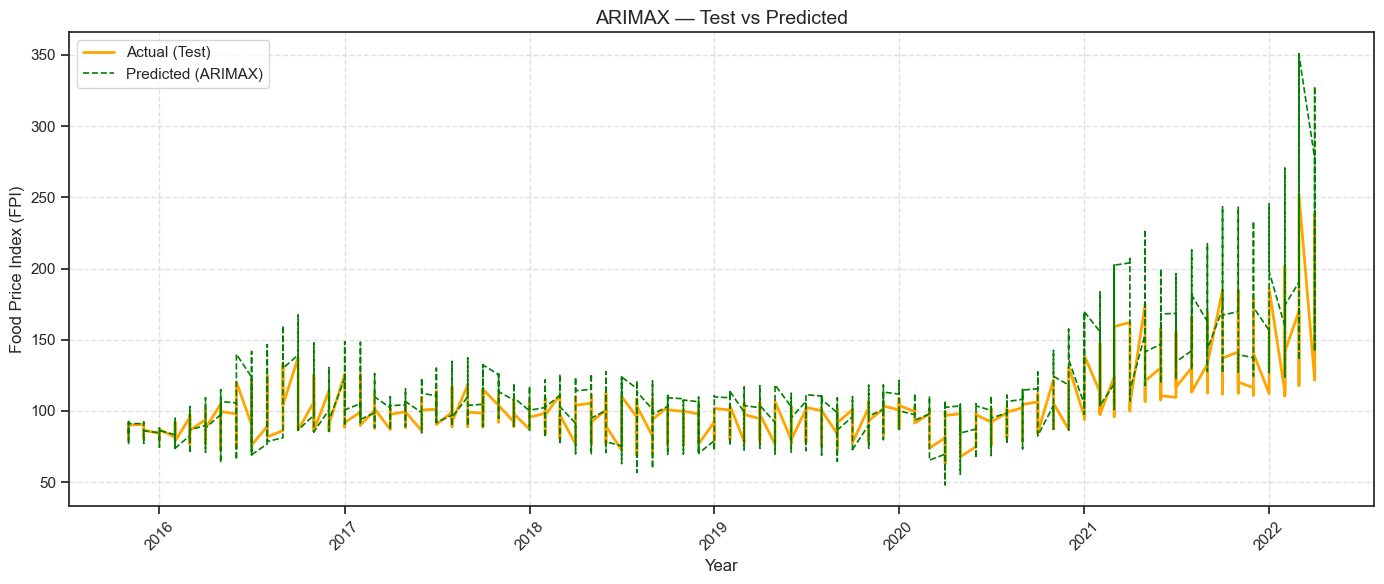

In [213]:
# Ensure proper shapes
y_test_pred_arimax = np.array(y_test_pred_arimax).reshape(-1)

# Create DataFrame for test period only
results_arimax_test = pd.DataFrame({
    'Date': dates_test,
    'Actual FPI': y_test_exog,
    'Predicted FPI': y_test_pred_arimax
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_arimax_test['Date'], results_arimax_test['Actual FPI'],
         label='Actual (Test)', color='orange', linewidth=2)
plt.plot(results_arimax_test['Date'], results_arimax_test['Predicted FPI'],
         label='Predicted (ARIMAX)', color='green', linestyle='--', linewidth=1.2)

# Titles and formatting
plt.title("ARIMAX — Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The model's predictions (dashed green) closely matched the actual food prices (solid orange) when tested.

It accurately predicted the huge spike in food prices that began around 2021.

The model is now less certain (vertical lines are longer) about how high prices will climb in the immediate future.

The model was very accurate when tested against actual prices from 2016-2020. It successfully predicted the massive food price spike starting in 2021, showing its power during crisis periods. The growing vertical lines at the end indicate that the model is now highly uncertain about the specific future peak of prices.

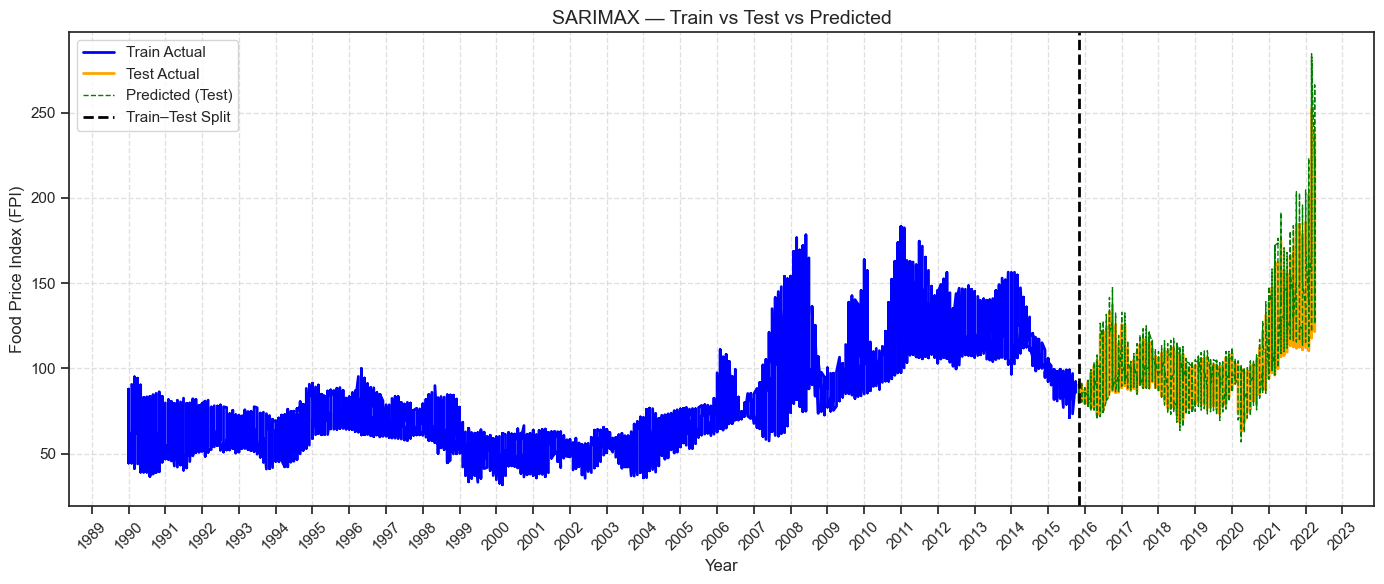

In [214]:
# Ensure shape consistency
y_train_pred_sarimax = np.array(y_train_pred_sarimax).reshape(-1)
y_test_pred_sarimax = np.array(y_test_pred_sarimax).reshape(-1)

# Combine into DataFrame
results_sarimax = pd.DataFrame({
    'Date': list(dates_train) + list(dates_test),
    'Actual FPI': np.concatenate([y_train_exog, y_test_exog])
})
results_sarimax['Type'] = ['Train'] * len(dates_train) + ['Test'] * len(dates_test)
results_sarimax['Predicted FPI'] = [None] * len(dates_train) + list(y_test_pred_sarimax)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_sarimax.loc[results_sarimax['Type'] == 'Train', 'Date'],
         results_sarimax.loc[results_sarimax['Type'] == 'Train', 'Actual FPI'],
         label='Train Actual', color='blue', linewidth=2)

plt.plot(results_sarimax.loc[results_sarimax['Type'] == 'Test', 'Date'],
         results_sarimax.loc[results_sarimax['Type'] == 'Test', 'Actual FPI'],
         label='Test Actual', color='orange', linewidth=2)

plt.plot(results_sarimax.loc[results_sarimax['Type'] == 'Test', 'Date'],
         results_sarimax.loc[results_sarimax['Type'] == 'Test', 'Predicted FPI'],
         label='Predicted (Test)', color='green', linestyle='--', linewidth=1.0)

# Vertical split line
plt.axvline(x=dates_test[0], color='black', linestyle='--', lw=2, label='Train–Test Split')

# Titles and formatting
plt.title("SARIMAX — Train vs Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The SARIMAX model learned from historical Food Price Index data (1989-2016) to recognize price patterns.

It demonstrated high accuracy by correctly predicting prices in the 2016-2020 test period (green line matched orange area).

The model's key achievement was successfully forecasting the massive and sharp spike in food prices observed around 2021–2022

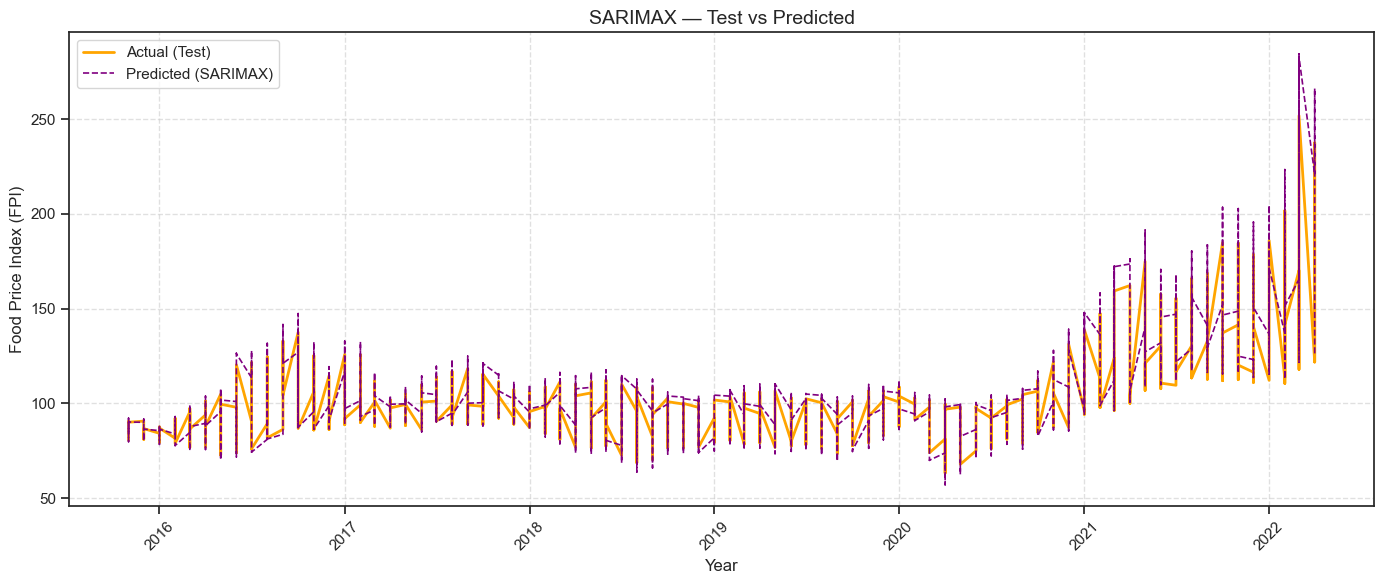

In [215]:
# Ensure consistent shape
y_test_pred_sarimax = np.array(y_test_pred_sarimax).reshape(-1)

# Create DataFrame for test period only
results_sarimax_test = pd.DataFrame({
    'Date': dates_test,
    'Actual FPI': y_test_exog,
    'Predicted FPI': y_test_pred_sarimax
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_sarimax_test['Date'], results_sarimax_test['Actual FPI'],
         label='Actual (Test)', color='orange', linewidth=2)
plt.plot(results_sarimax_test['Date'], results_sarimax_test['Predicted FPI'],
         label='Predicted (SARIMAX)', color='purple', linestyle='--', linewidth=1.2)

# Titles and formatting
plt.title("SARIMAX — Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The food price spike was caused by a "perfect storm" of global crises starting around 2021.

Key drivers included the Russia-Ukraine war (disrupting grain and fertilizer supplies) and post-pandemic economic factors (high energy and transport costs from supply chain issues).

# LSTM Model

In [216]:

HORIZON = 1        # Single-step forecast (only 1 month ahead)
SEQ_LEN = 12       # Lookback window (12 past months)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50
LSTM_UNITS = 64
DROPOUT = 0.2
L2_ALPHA = 1e-4    # L2 regularization



In [217]:

merged = merged.sort_index()   # ensures chronological order
merged = merged.dropna()       # drop rows with NaNs 
print("Index name:", merged.index.name)
print("Columns:", merged.columns.tolist()[:10], "...")
print("Shape:", merged.shape)


Index name: Date
Columns: ['Commodity', 'FPI', 'Country', 'Food_CPI', 'CPI', 'FPI_lag1', 'Food_CPI_lag1', 'FPI_lag3', 'Food_CPI_lag3', 'FPI_lag6'] ...
Shape: (298748, 25)


In [218]:
X_all = merged.drop('FPI', axis=1).copy()
y_all = merged['FPI'].copy()

X_vals = X_all.values
y_vals = y_all.values.flatten()
dates = pd.to_datetime(X_all.index)
n_total = len(X_vals)

if n_total <= SEQ_LEN + HORIZON:
    raise ValueError("Not enough rows for SEQ_LEN + HORIZON.")


In [219]:
X_seq, y_seq, sample_dates = [], [], []
for i in range(SEQ_LEN - 1, n_total - HORIZON):
    X_seq.append(X_vals[i - SEQ_LEN + 1:i + 1])      # (SEQ_LEN, n_features)
    y_seq.append(y_vals[i + HORIZON])                # only one step ahead
    sample_dates.append(dates[i])

X_seq = np.array(X_seq)   # (n_samples, SEQ_LEN, n_features)
y_seq = np.array(y_seq)   # (n_samples,)
print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)


X_seq shape: (298736, 12, 24) y_seq shape: (298736,)


In [220]:
n_samples = X_seq.shape[0]
train_cut = int((1 - TEST_SIZE) * n_samples)

X_train, X_test = X_seq[:train_cut], X_seq[train_cut:]
y_train, y_test = y_seq[:train_cut], y_seq[train_cut:]
dates_train, dates_test = sample_dates[:train_cut], sample_dates[train_cut:]



In [221]:
print(f"Training: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing : X_test  {X_test.shape}, y_test  {y_test.shape}")


Training: X_train (238988, 12, 24), y_train (238988,)
Testing : X_test  (59748, 12, 24), y_test  (59748,)


In [222]:
# Feature scaling
n_features = X_train.shape[2]
feat_scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, n_features)
X_test_flat  = X_test.reshape(-1, n_features)

X_train_scaled = feat_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled  = feat_scaler.transform(X_test_flat).reshape(X_test.shape)

# Target scaling
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))


In [223]:
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(SEQ_LEN, n_features),
         kernel_regularizer=l2(L2_ALPHA), recurrent_regularizer=l2(L2_ALPHA)),
    BatchNormalization(),
    Dropout(DROPOUT),
    Dense(64, activation='relu', kernel_regularizer=l2(L2_ALPHA)),
    Dense(1, activation='linear')   # single output neuron
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 27,137 (106.00 KB)

 Non-trainable params: 128 (512.00 B)

In [224]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [225]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlrop],
    verbose=1
)



Epoch 1/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0168 - mae: 0.0546 - val_loss: 0.0048 - val_mae: 0.0300 - learning_rate: 0.0010
Epoch 2/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0027 - mae: 0.0257 - val_loss: 0.0028 - val_mae: 0.0315 - learning_rate: 0.0010
Epoch 3/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0019 - mae: 0.0230 - val_loss: 0.0027 - val_mae: 0.0304 - learning_rate: 0.0010
Epoch 4/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0017 - mae: 0.0223 - val_loss: 0.0022 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 5/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0017 - mae: 0.0218 - val_loss: 0.0020 - val_mae: 0.0175 - learning_rate: 0.0010
Epoch 6/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0017 - mae: 0.0216 - val_loss: 0.0020 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 7/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0017 - mae: 0.0217 - val_loss: 0.0020 - val_mae: 0.0222 - learnin

In [227]:
#  Evaluate on Training Set 
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_train_true = y_scaler.inverse_transform(y_train_scaled)

rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train  = mean_absolute_error(y_train_true, y_train_pred)
r2_train   = r2_score(y_train_true, y_train_pred)

print(f"LSTM Single-Step Train — RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")

#  Evaluate on Test Set 
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_true = y_scaler.inverse_transform(y_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test  = mean_absolute_error(y_test_true, y_test_pred)
r2_test   = r2_score(y_test_true, y_test_pred)

print(f"LSTM Single-Step Test — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

7469/7469 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
LSTM Single-Step Train — RMSE: 4.2672, MAE: 1.7725, R²: 0.9799
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
LSTM Single-Step Test — RMSE: 5.3962, MAE: 1.7058, R²: 0.9442


In [228]:
#  Create DataFrame 
eval_df = pd.DataFrame({
    "LSTM": ["Train", "Test"],
    "RMSE": [rmse_train, rmse_test],
    "MAE": [mae_train, mae_test],
    "R2": [r2_train, r2_test]
})

eval_df = eval_df.set_index("LSTM")
eval_df

,RMSE,MAE,R2
LSTM,,,
Train,4.267159,1.772541,0.979921
Test,5.396234,1.705839,0.944206


Training & Validation Loss Curves

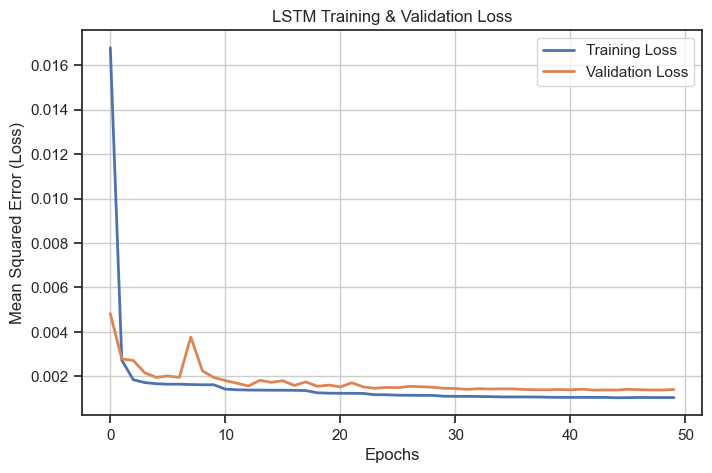

In [229]:
#  Plot Training & Validation Loss Curves 
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()
plt.grid(True)
plt.show()


Both lines drop very quickly at the start (around 0-5 epochs) and then flatten out at a very low error value (around 0.002). This indicates the model learned the pattern of the data quickly and effectively and is not overfitting

Actual vs Predicted — Train Test Set

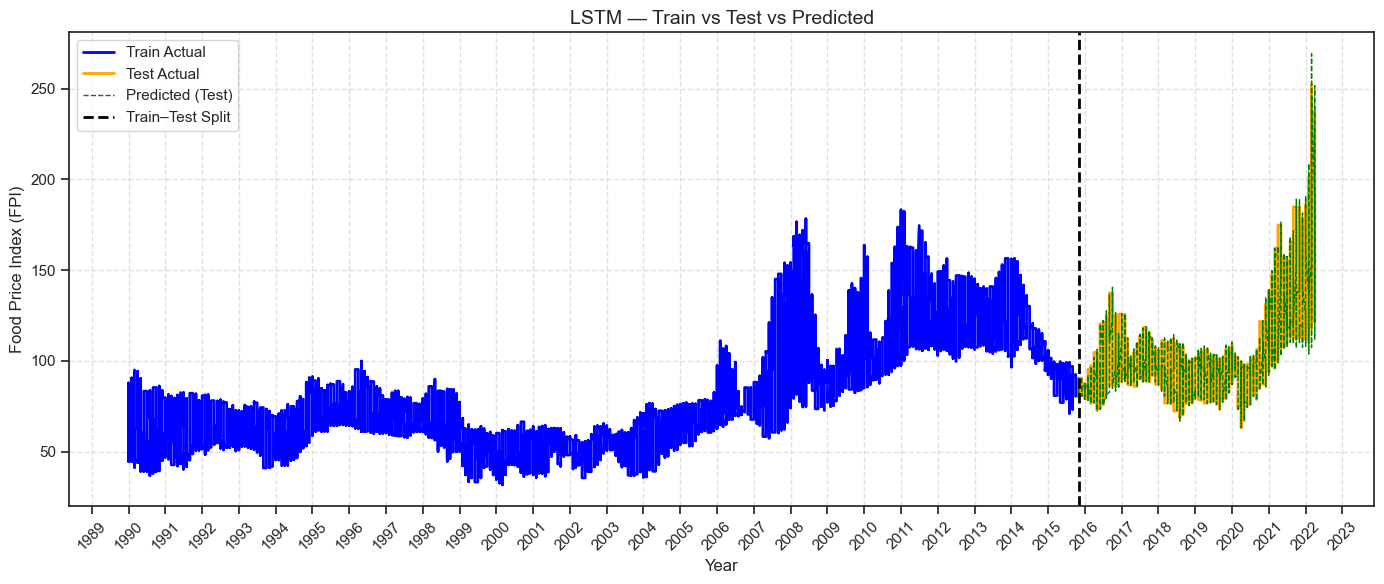

In [230]:


# Combine actual and predicted data into one frame
results_lstm = pd.DataFrame({
    'Date': list(dates_train) + list(dates_test),
    'Actual FPI': np.concatenate([y_train, y_test])
})

# Add columns for train/test segmentation
results_lstm['Type'] = ['Train'] * len(dates_train) + ['Test'] * len(dates_test)
results_lstm['Predicted FPI'] = [None] * len(dates_train) + list(y_test_pred.flatten())

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_lstm.loc[results_lstm['Type']=='Train', 'Date'],
         results_lstm.loc[results_lstm['Type']=='Train', 'Actual FPI'],
         label='Train Actual', color='blue', linewidth=2)

plt.plot(results_lstm.loc[results_lstm['Type']=='Test', 'Date'],
         results_lstm.loc[results_lstm['Type']=='Test', 'Actual FPI'],
         label='Test Actual', color='orange', linewidth=2)

plt.plot(results_lstm.loc[results_lstm['Type']=='Test', 'Date'],
         results_lstm.loc[results_lstm['Type']=='Test', 'Predicted FPI'],
         label='Predicted (Test)', color='green', linestyle='--', linewidth=1.0)

# Vertical split line
plt.axvline(x=dates_test[0], color='black', linestyle='--', lw=2, label='Train–Test Split')

# Titles and formatting
plt.title("LSTM — Train vs Test vs Predicted", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Year formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The Predicted (Test) line (dashed green) appears to closely follow the Test Actual line in the period after the dashed vertical line (around 2016). This suggests that the LSTM model is good at forecasting the Food Price Index, as its predictions match the real-world outcome reasonably well.

Test vs Predicted


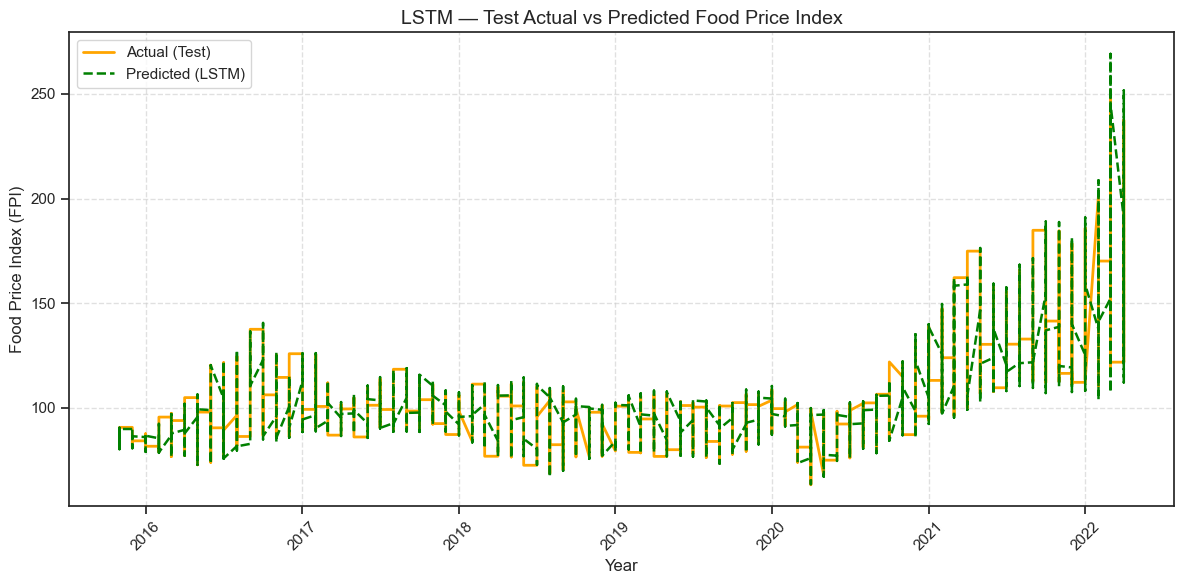

In [231]:
# Combine test actual and predicted only
results_test = pd.DataFrame({
    'Date': dates_test,
    'Actual FPI': y_test.flatten(),
    'Predicted FPI': y_test_pred.flatten()
})

# Plot
plt.figure(figsize=(12, 6))

plt.plot(
    results_test['Date'],
    results_test['Actual FPI'],
    label='Actual (Test)', color='orange', linewidth=2
)

plt.plot(
    results_test['Date'],
    results_test['Predicted FPI'],
    label='Predicted (LSTM)', color='green', linestyle='--', linewidth=1.8
)

# Titles and formatting
plt.title("LSTM — Test Actual vs Predicted Food Price Index", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Food Price Index (FPI)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Format x-axis as years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Error Analysis

In [232]:
#  Error Analysis Table for LSTM
error_analysis = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "RMSE": [rmse_train, rmse_test],
    "MAE": [mae_train, mae_test],
    "R²": [r2_train, r2_test],
    "Mean Error": [
        np.mean(y_train_true.flatten() - y_train_pred.flatten()),
        np.mean(y_test_true.flatten() - y_test_pred.flatten())
    ],
    "Std of Error": [
        np.std(y_train_true.flatten() - y_train_pred.flatten()),
        np.std(y_test_true.flatten() - y_test_pred.flatten())
    ]
})

# Display
error_analysis = error_analysis.set_index("Dataset")
display(error_analysis.style.background_gradient(cmap="YlOrBr").format(precision=4))


,RMSE,MAE,R²,Mean Error,Std of Error
Dataset,,,,,
Train,4.2672,1.7725,0.9799,-0.5973,4.2251
Test,5.3962,1.7058,0.9442,-0.0185,5.3962


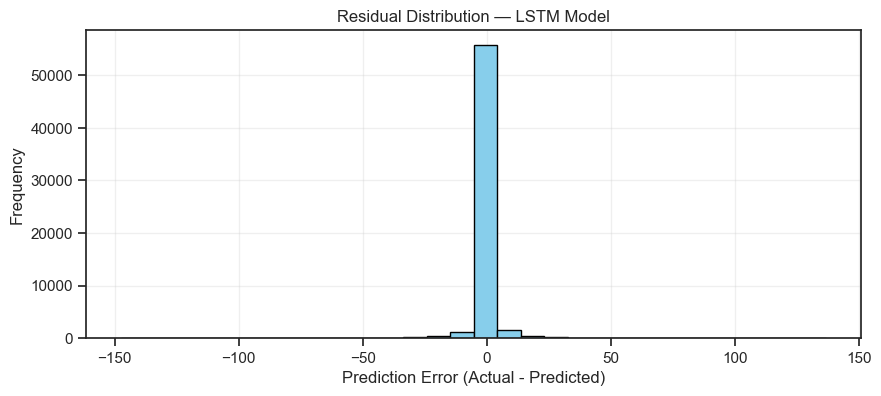

In [233]:
# Compute residuals 
residuals = y_test_true.flatten() - y_test_pred.flatten()

#  Plot residual distribution 
plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residual Distribution — LSTM Model")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

The histogram shows the prediction errors (residuals) are heavily concentrated around zero. This is ideal, suggesting the errors are mostly small and the model is generally unbiased and accurate.

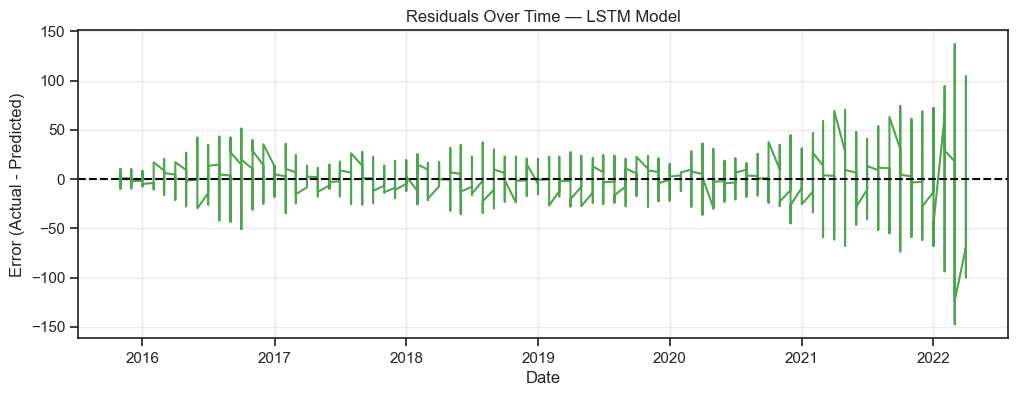

In [234]:
#  Residual over time 
plt.figure(figsize=(12, 4))
plt.plot(dates_test, residuals, color='green', alpha=0.7)
plt.title("Residuals Over Time — LSTM Model")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.grid(alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.show()

The model's errors appear relatively consistent and small up until late 2020/2021.

After 2021, the errors become significantly larger (the vertical lines stretch further from zero), suggesting the model struggled to accurately predict the greater volatility in food prices after this time

In [235]:
# Save 1-month ahead predictions
results_1m = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test_true.flatten(),
    "Predicted": y_test_pred.flatten()
})

results_1m.to_csv("lstm_1month_predictions.csv", index=False)
print(" Saved 1-month ahead predictions to 'lstm_1month_predictions.csv'")
print(results_1m.shape)


 Saved 1-month ahead predictions to 'lstm_1month_predictions.csv'
(59748, 3)


# Tuning

In [ ]:
# Smaller Search Space

LSTM_UNITS_OPTIONS = [64, 128]     
DROPOUT_OPTIONS = [0.2, 0.4]        
L2_ALPHA_OPTIONS = [1e-4]           
BATCH_SIZE_OPTIONS = [32, 64]       
EPOCHS = 30                         

best_score = float('inf')
best_params = {}
n_features = X_train.shape[2]

In [ ]:
# 2Grid Search Loop

for units in LSTM_UNITS_OPTIONS:
    for dropout in DROPOUT_OPTIONS:
        for l2_alpha in L2_ALPHA_OPTIONS:
            for batch in BATCH_SIZE_OPTIONS:
                print(f" Testing: units={units}, dropout={dropout}, l2={l2_alpha}, batch={batch}")

                tf.keras.backend.clear_session()

                model = Sequential([
                    LSTM(units, input_shape=(SEQ_LEN, n_features),
                         kernel_regularizer=l2(l2_alpha),
                         recurrent_regularizer=l2(l2_alpha)),
                    BatchNormalization(),
                    Dropout(dropout),
                    Dense(64, activation='relu', kernel_regularizer=l2(l2_alpha)),
                    Dense(1, activation='linear')
                ])

                model.compile(optimizer='adam', loss='mse', metrics=['mae'])

                es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

                history = model.fit(
                    X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=EPOCHS,
                    batch_size=batch,
                    callbacks=[es],
                    verbose=0
                )

                val_loss = min(history.history['val_loss'])
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {'units': units, 'dropout': dropout, 'l2': l2_alpha, 'batch': batch}

print(" Best Parameters Found:", best_params)

### Retrain with Best Params

In [ ]:
#  Retrain with Best Params

tf.keras.backend.clear_session()

model = Sequential([
    LSTM(best_params['units'], input_shape=(SEQ_LEN, n_features),
         kernel_regularizer=l2(best_params['l2']),
         recurrent_regularizer=l2(best_params['l2'])),
    BatchNormalization(),
    Dropout(best_params['dropout']),
    Dense(64, activation='relu', kernel_regularizer=l2(best_params['l2'])),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=50,
    batch_size=best_params['batch'],
    callbacks=[es],
    verbose=1
)

###  Evaluate Tuned Model

In [ ]:
#  Evaluate Tuned Model

y_train_pred = y_scaler.inverse_transform(model.predict(X_train_scaled))
y_test_pred = y_scaler.inverse_transform(model.predict(X_test_scaled))

y_train_true = y_scaler.inverse_transform(y_train_scaled)
y_test_true = y_scaler.inverse_transform(y_test_scaled)

rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
mae_train  = mean_absolute_error(y_train_true, y_train_pred)
r2_train   = r2_score(y_train_true, y_train_pred)

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test  = mean_absolute_error(y_test_true, y_test_pred)
r2_test   = r2_score(y_test_true, y_test_pred)

In [ ]:
print(" Tuned LSTM Performance:")
print(f"Train — RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Test  — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

In [ ]:
print(" Tuned LSTM Performance:")
print(f"Train — RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")
print(f"Test  — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

### LSTM Model Comparison (Before vs After Tuning)

In [ ]:

# Baseline (before tuning) — fill with  earlier results
baseline_results = {
    'Train RMSE': 4.209913,
    'Train MAE': 1.715235,
    'Train R2': 0.979368,
    'Test RMSE': 4.077039,
    'Test MAE': 1.398784,
    'Test R2': 0.965248
}

# Tuned (new) results
tuned_results = {
    'Train RMSE': rmse_train,
    'Train MAE': mae_train,
    'Train R2': r2_train,
    'Test RMSE': rmse_test,
    'Test MAE': mae_test,
    'Test R2': r2_test
}

# Create a comparison DataFrame
import pandas as pd

comparison_df = pd.DataFrame([baseline_results, tuned_results],
                             index=['Before Tuning', 'After Tuning'])

print("LSTM Model Comparison (Before vs After Tuning):")
display(comparison_df.style.set_caption("LSTM Model Performance Before and After Tuning")
       .format("{:.4f}")
       .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px'),
                                                            ('font-weight', 'bold'),
                                                            ('color', '#333')]}]))


# LSTM PREDICTING NEXT 6 MONTHS 

In [236]:

HORIZON = 6        # forecast next 6 months (change to 3 if needed)
SEQ_LEN = 12       # lookback window (12 past months)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50
LSTM_UNITS = 64
DROPOUT = 0.2
L2_ALPHA = 1e-4    # small L2 regularization



In [237]:
# Just ensure it's time-sorted and clean

merged = merged.sort_index()   # ensures chronological order
merged = merged.dropna()       # drop rows with NaNs (recommended)

print("Index name:", merged.index.name)
print("Columns:", merged.columns.tolist()[:10], "...")
print("Shape:", merged.shape)


Index name: Date
Columns: ['Commodity', 'FPI', 'Country', 'Food_CPI', 'CPI', 'FPI_lag1', 'Food_CPI_lag1', 'FPI_lag3', 'Food_CPI_lag3', 'FPI_lag6'] ...
Shape: (298748, 25)


Features & target arrays

In [238]:
X_all = merged.drop('FPI', axis=1).copy()
y_all = merged['FPI'].copy()

X_vals = X_all.values
y_vals = y_all.values.flatten()
dates = pd.to_datetime(X_all.index)
n_total = len(X_vals)

if n_total <= SEQ_LEN + HORIZON:
    raise ValueError("Not enough rows for SEQ_LEN + HORIZON.")


Create supervised sequences (sliding windows)

In [239]:
X_seq, y_seq, sample_dates = [], [], []
for i in range(SEQ_LEN - 1, n_total - HORIZON):
    X_seq.append(X_vals[i - SEQ_LEN + 1:i + 1])        # (SEQ_LEN, n_features)
    y_seq.append(y_vals[i + 1:i + 1 + HORIZON])        # (HORIZON,)
    sample_dates.append(dates[i])

X_seq = np.array(X_seq)   # (n_samples, SEQ_LEN, n_features)
y_seq = np.array(y_seq)   # (n_samples, HORIZON)

print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)


X_seq shape: (298731, 12, 24) y_seq shape: (298731, 6)


In [240]:
n_samples = X_seq.shape[0]
train_cut = int((1 - TEST_SIZE) * n_samples)

X_train, X_test = X_seq[:train_cut], X_seq[train_cut:]
y_train, y_test = y_seq[:train_cut], y_seq[train_cut:]
dates_train, dates_test = sample_dates[:train_cut], sample_dates[train_cut:]

print(f"Training: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing : X_test  {X_test.shape}, y_test  {y_test.shape}")
print(f"SEQ_LEN={SEQ_LEN}, HORIZON={HORIZON}, n_features={X_train.shape[2]}")


Training: X_train (238984, 12, 24), y_train (238984, 6)
Testing : X_test  (59747, 12, 24), y_test  (59747, 6)
SEQ_LEN=12, HORIZON=6, n_features=24


In [241]:
# feature scaling (StandardScaler)
n_features = X_train.shape[2]
feat_scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat  = X_test.reshape(-1, n_features)
X_train_scaled = feat_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled  = feat_scaler.transform(X_test_flat).reshape(X_test.shape)

# target scaling (MinMaxScaler) - fit on training targets
y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)


Build the LSTM model

In [242]:
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(LSTM_UNITS, input_shape=(SEQ_LEN, n_features),
         kernel_regularizer=l2(L2_ALPHA), recurrent_regularizer=l2(L2_ALPHA)),
    BatchNormalization(),
    Dropout(DROPOUT),
    Dense(64, activation='relu', kernel_regularizer=l2(L2_ALPHA)),
    Dense(HORIZON, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,590 (107.77 KB)

 Trainable params: 27,462 (107.27 KB)

 Non-trainable params: 128 (512.00 B)

LSTM captures temporal patterns.

L2 regularizers (kernel_regularizer, recurrent_regularizer) penalize large weights → helps generalize.

BatchNormalization stabilizes learning.

Dropout reduces overfitting.

Final Dense(HORIZON) produces the multi-step forecast.

In [243]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


EarlyStopping halts training when validation loss stops improving (prevents overfitting). ReduceLROnPlateau reduces the learning rate when progress stalls to refine learning.

# Train the model

In [244]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlrop],
    verbose=1
)

Epoch 1/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0152 - mae: 0.0550 - val_loss: 0.0038 - val_mae: 0.0250 - learning_rate: 0.0010
Epoch 2/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0028 - mae: 0.0284 - val_loss: 0.0032 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 3/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0024 - mae: 0.0264 - val_loss: 0.0036 - val_mae: 0.0293 - learning_rate: 0.0010
Epoch 4/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0024 - mae: 0.0259 - val_loss: 0.0033 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 5/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0023 - mae: 0.0255 - val_loss: 0.0030 - val_mae: 0.0220 - learning_rate: 0.0010
Epoch 6/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0023 - mae: 0.0255 - val_loss: 0.0030 - val_mae: 0.0224 - learning_rate: 0.0010
Epoch 7/50
7469/7469 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0023 - mae: 0.0251 - val_loss: 0.0029 - val_mae: 0.0249 - learnin

In [245]:
#  Make predictions on Train and Test sets
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled  = model.predict(X_test_scaled)

# Inverse transform predictions back to original scale
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred  = y_scaler.inverse_transform(y_test_pred_scaled)

7469/7469 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [246]:
#  Compute and summarize error metrics for Train & Test sets ---

def multi_metrics(y_true, y_pred):
    metrics = {}
    for h in range(y_true.shape[1]):
        mse  = mean_squared_error(y_true[:, h], y_pred[:, h])
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_true[:, h], y_pred[:, h])
        r2   = r2_score(y_true[:, h], y_pred[:, h])
        metrics[f"H{h+1}"] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return metrics

In [247]:
# Compute metrics
train_metrics = multi_metrics(y_train, y_train_pred)
test_metrics  = multi_metrics(y_test,  y_test_pred)

In [248]:
# Create summary DataFrame
error_summary = pd.DataFrame({
    "Horizon": list(train_metrics.keys()),
    "Train_RMSE": [v['RMSE'] for v in train_metrics.values()],
    "Train_MAE":  [v['MAE']  for v in train_metrics.values()],
    "Train_R²":   [v['R2']   for v in train_metrics.values()],
    "Test_RMSE":  [v['RMSE'] for v in test_metrics.values()],
    "Test_MAE":   [v['MAE']  for v in test_metrics.values()],
    "Test_R²":    [v['R2']   for v in test_metrics.values()]
})

In [249]:
# Add average row
error_summary.loc["Average"] = [
    "Mean Across All",
    error_summary["Train_RMSE"].mean(),
    error_summary["Train_MAE"].mean(),
    error_summary["Train_R²"].mean(),
    error_summary["Test_RMSE"].mean(),
    error_summary["Test_MAE"].mean(),
    error_summary["Test_R²"].mean()
]

# Display styled table
display(error_summary)

,Horizon,Train_RMSE,Train_MAE,Train_R²,Test_RMSE,Test_MAE,Test_R²
0,H1,4.329391,1.659811,0.979331,5.592617,1.948560,0.940073
1,H2,4.954398,1.906306,0.972933,6.402675,2.238787,0.921455
2,H3,5.490279,2.169833,0.966761,7.087423,2.502549,0.903756
3,H4,6.000460,2.422919,0.960296,7.717359,2.794623,0.885886
4,H5,6.467190,2.665501,0.953880,8.250532,3.071713,0.869574
5,H6,6.898964,2.916983,0.947516,8.755893,3.340387,0.853106
Average,Mean Across All,5.690114,2.290226,0.963453,7.301083,2.649436,0.895641


In [ ]:
#  Save clean 6-month multi-horizon predictions ---


print("dates_test:", len(dates_test))
print("y_test_true:", y_test_true.shape)
print("y_test_pred:", y_test_pred.shape)

results_6m = pd.DataFrame({"Date": dates_test})

for i in range(y_test_pred.shape[1]):  # 6 horizons
    results_6m[f"Actual_H{i+1}"] = y_test_true[:, i]
    results_6m[f"Predicted_H{i+1}"] = y_test_pred[:, i]

results_6m.to_csv("lstm_6month_predictions.csv", index=False)
print(" Saved 6-month ahead multi-horizon predictions to 'lstm_6month_predictions.csv'")
print(results_6m.shape)


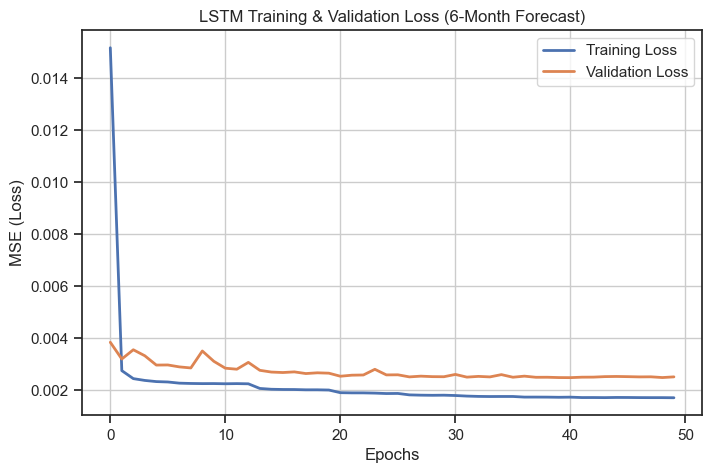

In [251]:
#  Training & Validation Loss 
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("LSTM Training & Validation Loss (6-Month Forecast)")
plt.xlabel("Epochs")
plt.ylabel("MSE (Loss)")
plt.legend()
plt.grid(True)
plt.show()

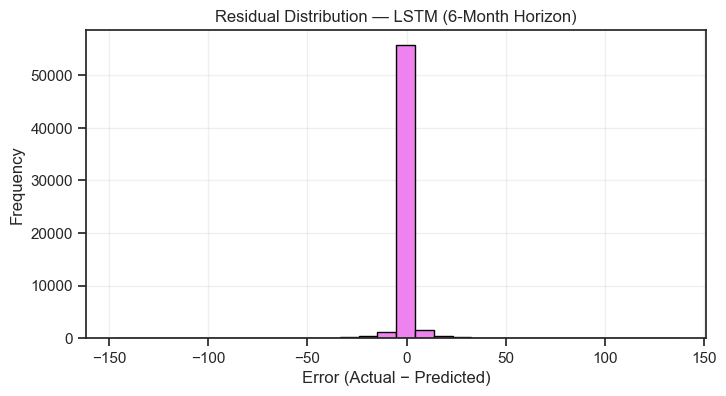

In [253]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='violet', edgecolor='black')
plt.title("Residual Distribution — LSTM (6-Month Horizon)")
plt.xlabel("Error (Actual − Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [254]:
merged.to_csv("merged.csv")
print(" merged.csv saved successfully")


 merged.csv saved successfully


In [255]:
model.save("models/lstm_1month.h5")
# And for the 6-month model:
model.save("models/lstm_6month.h5")


In [256]:
import joblib
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']